# Mod 4 - Classifying Tweets as Hate Speech, Offensive Language, or Neither

Please fill out:
* Student name: Max Steele
* Student pace: Full Time
* Scheduled project review date/time: Wednesday, November 4 at 4 PM
* Instructor name: James Irving
* Blog post URL: <a href="https://zero731.github.io/model_selection_validation_and_tuning">Model Selection, Validation, and Tuning</a>

**A warning and disclaimer:**<br>
- **Due to the nature of this project, this notebook contains content that is racist, sexist, ableist, homophobic, transphobic, and offensive in numerous other ways.**
- **At certain points throughout this project I use the word "queer", which I realize some people may find offensive. However, this is because I identify as queer. This word has worked its way into my regular vocabulary and I have found that this reclamation of a slur is the best way to succinctly describe my identity.** This is also an example of just how difficult it can be to classify hate speech without much context, but that is what I attempt to do with the models in this project.

<font size=3rem>
    
- **[Introduction](#Introduction)<br>**
- **[OBTAIN](#OBTAIN)**<br>
- **[SCRUB](#SCRUB)**<br>
- **[EXPLORE](#EXPLORE)**<br>
- **[MODEL](#MODEL)**<br>
- **[INTERPRET](#INTERPRET)**<br>
- **[Conclusions/Recommendations](#Conclusions/Recommendations)<br>**
</font>

# Introduction

My goal for this project was to build a classifier to correctly label tweets as either "Hate Speech", "Offensive Language", or "Neither". The main purpose of my modeling efforts was to make these classifications as accurately as possible. Essentially I want to be able to catch instances of hate speech as often as possible without flagging tweets that merely contain offensive language or nothing offensive too frequently as hate speech. Such a model could be useful for helping social media platforms like Twitter enforce policies against hate speech and hateful conduct without unnecessarily limiting other forms of expression (even when that expression may be offensive, but isn't technically hate speech.

Twitter's full hateful conduct policy can be found <a href="https://zero731.github.io/model_selection_validation_and_tuning">here</a>. To summarize, the company's goal is to allow for freedom of expression and the "representation of a diverse range of perspectives". Twitter acknowledges that hate speech and otherwise "hateful conduct" is often used on social media as a means to promote violence against, threaten, or otherwise harass and abuse people "on the basis race, ethnicity, national origin, caste, sexual orientation, gender, gender identity, religious affiliation, age, disability, or serious disease." So while hate speech technically represents a certain type of perspective or voice, it is often used online to silence and otherwise harm marginalized and historically underrepresented communities. Twitter specifically prohibits the following under its hateful conduct policy:
 - "Violent threats"
 - "Wishing, hoping or calling for serious harm on a person or group of people"
 - "References to mass murder, violent events, or specific means of violence where protected groups have been the primary targets or victims"
 - "Inciting fear about a protected category"
 - "Repeated and/or non-consensual slurs, epithets, racist and sexist tropes, or other content that degrades someone"
 
Aiming to correctly classify such tweets as hate speech, I used the dataset of tweets made available <a href="https://github.com/t-davidson/hate-speech-and-offensive-language">here</a> that was used as part of a research effort published in the following paper:
```
@inproceedings{hateoffensive,
  title = {Automated Hate Speech Detection and the Problem of Offensive Language},
  author = {Davidson, Thomas and Warmsley, Dana and Macy, Michael and Weber, Ingmar}, 
  booktitle = {Proceedings of the 11th International AAAI Conference on Web and Social Media},
  series = {ICWSM '17},
  year = {2017},
  location = {Montreal, Canada},
  pages = {512-515}
  }
```
This dataset contained tweets that had been labeled as belonging to one of the three categories based on votes (the class with the majority of votes for a specific tweet became its label) and were not classifications made by Twitter itself.

I followed the OSEMN data science process to approach this problem. Since there are no missing values in the dataset, the bulk of scrubbing and exploring dealt with how to process the text of each tweet prior to analysis. I found the classes of the original/full dataset, a total of 24,783 tweets, to be extremely imbalanced (77.4% offensive language, 16.8% neither, and 5.8% hate speech). To address this, I chose to undersample the offensive language class. I randomly sampled a subset of 4,407 of the original 19,190 offensive tweets. Combined with all the hate speech and neither tweets, the dataset used for modeling and analysis consisted of 10,000 tweets. The offensive language and neither classes were nearly completely balanced, while hate speech still made up the minority class. I did initially attempt modeling with a completely balanced dataset where both offensive language and neither were undersampled to exactly match the number of hate speech tweets. However these models were substantially less accurate than those built with the dataset of 10,000. This is not necessarily surprising since the completely balanced set consisted of only 4,290 and natural language processing tends to work better with larger bodies of texts.

To get the tweets ready for modeling, I cleaned them of urls, mentions, emojis, hashtags (only the symbols, not the text of the hastag) and other symbols. I used the tweet tokenizer when vectorizing the text and set the tokenizer to reduce the length of repeated characters (so that things like "boyyyyyyyyy", "boyyyyy", and "boyyy" would all be treated as the same word: "boyyy") and somewhat reduce dimensionality. Stop words and punctuation were also removed as part of the vectorizing process. I built, tested, and attempted to tune the following classifiers:
 - Random Forest
 - Multinomial Naive Bayes
 - LinearSVC
 - XGradient Boosted
Each of the above was tested using first scikit learn's CountVectorizer, then compared with scikit learn's TfidfVectorizer. Across all model types the CountVectorizer tended to perform at least slightly better. Each of the classifiers was tuned using GridSearchCV to test combinations of hyperparameters. The classifier with the best overall performance (a LinearSVC classifier using CountVectorizer) was then rebuilt using the same parameters but on a lemmatized version of the data. This very marginally improved performance.


# OBTAIN

In [1]:
## Import Numpy and set random seed for notebook
import numpy as np
np.random.seed(319)

In [2]:
## Import functions made specifically for this project
from project_functions import *

In [3]:
## Import remaining necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime as dt
from tzlocal import get_localzone

In [4]:
## Import and preview dataset
full_df = pd.read_csv('Data/orig_labeled_data.csv', index_col=0)
full_df.head()

count  hate_speech  offensive_language  neither  class  \
0      3            0                   0        3      2   
1      3            0                   3        0      1   
2      3            0                   3        0      1   
3      3            0                   2        1      1   
4      6            0                   6        0      1   

                                               tweet  
0  !!! RT @mayasolovely: As a woman you shouldn't...  
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...  
2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...  
3  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...  
4  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...

In [5]:
## View info for records and columns
full_df.info()
# No missing values at all
# All variables as integers except for tweets as strings

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24783 entries, 0 to 25296
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   count               24783 non-null  int64 
 1   hate_speech         24783 non-null  int64 
 2   offensive_language  24783 non-null  int64 
 3   neither             24783 non-null  int64 
 4   class               24783 non-null  int64 
 5   tweet               24783 non-null  object
dtypes: int64(5), object(1)
memory usage: 1.3+ MB


In [6]:
## Create column that translates number codes into class names to make things easier to keep track of
# Create a dict of values to be mapped
class_dict = {0: 'hate speech', 1: 'offensive', 2: 'neither'}

# Replace keys (0, 1, and 2) with corresponding values and preview dataset
full_df['class_code'] = full_df['class']
full_df['class'] = full_df['class_code'].map(class_dict)
full_df.head()

count  hate_speech  offensive_language  neither      class  \
0      3            0                   0        3    neither   
1      3            0                   3        0  offensive   
2      3            0                   3        0  offensive   
3      3            0                   2        1  offensive   
4      6            0                   6        0  offensive   

                                               tweet  class_code  
0  !!! RT @mayasolovely: As a woman you shouldn't...           2  
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...           1  
2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...           1  
3  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...           1  
4  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...           1

In [7]:
## Print value counts and percentages of classes for full dataset
check_unique(full_df, 'class') 
# Note: pretty extreme imbalance of classes

count         %
offensive    19190  0.774321
neither       4163  0.167978
hate speech   1430  0.057701

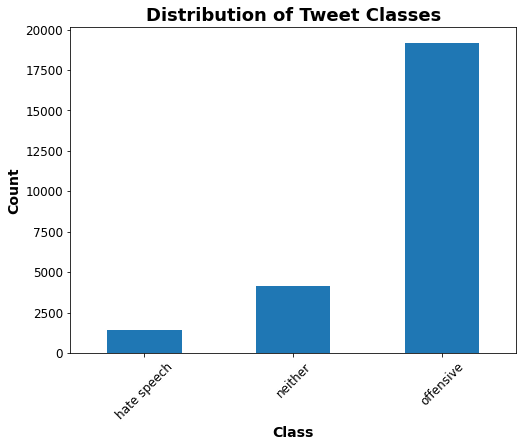

In [8]:
## Plot the distribution of tweets by true labeled class
plt.figure(figsize=(8,6))
full_df.groupby('class').tweet.count().plot.bar(ylim=0)
plt.xlabel('Class', fontsize=14, fontweight='bold')
plt.ylabel('Count', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.title('Distribution of Tweet Classes', fontsize=18, fontweight='bold')
plt.show()

In [9]:
## Print value counts and percentages of tweets for full dataset
check_unique(full_df, 'tweet') # Each tweet only shows up once

count        %
RT @Brennanculp: But if you a hoe, do you. I ai...      1  0.00004
Pussy ass nigguh name Jesus. And his daddy              1  0.00004
... I just feel bad for the women that continua...      1  0.00004
&#8220;@jama_jam I'm not saying I'm for this bu...      1  0.00004
&#8220;@fabbymichelle: brian stfu &#128548;&#12...      1  0.00004
...                                                   ...      ...
@oliver_______ if you're making 300 clams for b...      1  0.00004
RT @HlGHKEY: If ya girl texts back slow you got...      1  0.00004
Put her in her place cause pussies don't get pu...      1  0.00004
RT @thelibraicon: &#128514;&#128514;&#128514; R...      1  0.00004
@JaiBrooks1 not funny u faggot                          1  0.00004

[24783 rows x 2 columns]

In [10]:
## Create df of all hate speech tweets
hate_df = full_df.groupby('class').get_group('hate speech')
hate_df.head()

count  hate_speech  offensive_language  neither        class  \
85       3            2                   1        0  hate speech   
90       3            3                   0        0  hate speech   
111      3            3                   0        0  hate speech   
186      3            3                   0        0  hate speech   
204      3            2                   1        0  hate speech   

                                                 tweet  class_code  
85   "@Blackman38Tide: @WhaleLookyHere @HowdyDowdy1...           0  
90   "@CB_Baby24: @white_thunduh alsarabsss" hes a ...           0  
111  "@DevilGrimz: @VigxRArts you're fucking gay, b...           0  
186  "@MarkRoundtreeJr: LMFAOOOO I HATE BLACK PEOPL...           0  
204  "@NoChillPaz: "At least I'm not a nigger" http...           0

In [11]:
## Create df of all offensive tweets
offensive_df = full_df.groupby('class').get_group('offensive')
offensive_df.head()

count  hate_speech  offensive_language  neither      class  \
1      3            0                   3        0  offensive   
2      3            0                   3        0  offensive   
3      3            0                   2        1  offensive   
4      6            0                   6        0  offensive   
5      3            1                   2        0  offensive   

                                               tweet  class_code  
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...           1  
2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...           1  
3  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...           1  
4  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...           1  
5  !!!!!!!!!!!!!!!!!!"@T_Madison_x: The shit just...           1

In [12]:
## Create df of a subset of offensive tweets (concatenate with other classes to address class imbalance)
offensive_df_subset = offensive_df.sample(4407, random_state=319)
offensive_df_subset.head()

count  hate_speech  offensive_language  neither      class  \
22117      3            0                   3        0  offensive   
8265       3            1                   2        0  offensive   
20786      3            0                   3        0  offensive   
4598       3            1                   2        0  offensive   
21540      3            0                   3        0  offensive   

                                                   tweet  class_code  
22117  Them quicc to blast bitches, them all about th...           1  
8265   Bitch and who the fuck r u am speak when the f...           1  
20786  RT @woohdakidd_74: @Shane_A1 &#128514;&#128514...           1  
4598   @RBesofii \nCants even fool a colored man wit ...           1  
21540  Sometimes females are just fucking retarded br...           1

In [13]:
## Create df of neither hate speech nor offensive tweets
neither_df = full_df.groupby('class').get_group('neither')
neither_df.head()

count  hate_speech  offensive_language  neither    class  \
0       3            0                   0        3  neither   
40      3            0                   1        2  neither   
63      3            0                   0        3  neither   
66      3            0                   1        2  neither   
67      3            0                   1        2  neither   

                                                tweet  class_code  
0   !!! RT @mayasolovely: As a woman you shouldn't...           2  
40    " momma said no pussy cats inside my doghouse "           2  
63  "@Addicted2Guys: -SimplyAddictedToGuys http://...           2  
66  "@AllAboutManFeet: http://t.co/3gzUpfuMev" woo...           2  
67  "@Allyhaaaaa: Lemmie eat a Oreo &amp; do these...           2

In [14]:
## Concatenate all hate speech tweets with subsets of offensive and neither tweets
 ## in order to balance classes a little more than in original df
df = pd.concat([hate_df, offensive_df_subset, neither_df], axis=0)
df.reset_index(inplace=True, drop=True)
## Inspect new df
display(df.head())
df.info()

count  hate_speech  offensive_language  neither        class  \
0      3            2                   1        0  hate speech   
1      3            3                   0        0  hate speech   
2      3            3                   0        0  hate speech   
3      3            3                   0        0  hate speech   
4      3            2                   1        0  hate speech   

                                               tweet  class_code  
0  "@Blackman38Tide: @WhaleLookyHere @HowdyDowdy1...           0  
1  "@CB_Baby24: @white_thunduh alsarabsss" hes a ...           0  
2  "@DevilGrimz: @VigxRArts you're fucking gay, b...           0  
3  "@MarkRoundtreeJr: LMFAOOOO I HATE BLACK PEOPL...           0  
4  "@NoChillPaz: "At least I'm not a nigger" http...           0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   count               10000 non-null  int64 
 1   hate_speech         10000 non-null  int64 
 2   offensive_language  10000 non-null  int64 
 3   neither             10000 non-null  int64 
 4   class               10000 non-null  object
 5   tweet               10000 non-null  object
 6   class_code          10000 non-null  int64 
dtypes: int64(5), object(2)
memory usage: 547.0+ KB


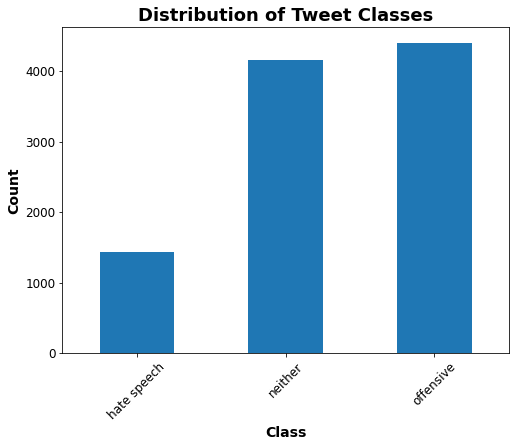

In [15]:
## Plot the distribution of tweets by true labeled class
plt.figure(figsize=(8,6))
df.groupby('class').tweet.count().plot.bar(ylim=0)
plt.xlabel('Class', fontsize=14, fontweight='bold')
plt.ylabel('Count', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.title('Distribution of Tweet Classes', fontsize=18, fontweight='bold')
plt.show()

# SCRUB

In [16]:
## Import libraries necessary for cleaning and preprocessing text data
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize, FreqDist
from nltk.collocations import *
from nltk.stem import WordNetLemmatizer 
from nltk import regexp_tokenize
import string
import re

In [17]:
## Define various parts of stop lists to use for cleaning tokenized tweets
# List of misspellings and shorthands that are equivalent to nltk's english stopwords
twitter_stops = ['bc', "i'm", 'im', "i'll", "i've" "it'll", 'hav',
                 "that's", 'dat', 'dats', 'u', 'da', 'n', "there's",
                 "he's", 'hes', "we'll", "we've", 'cus']

# Punctuation tokens to remove in addition to string.punctuation
more_punc = ['...', '“','”',"''",'’','``','. .', '..']

# List of numbers to remove
num = [0,1,2,3,4,5,6,7,8,9]

# Full list of all stop tokens (words and punctuation)
stopwords_list = stopwords.words('english') + list(string.punctuation) + twitter_stops + more_punc + num

# List of punctuation stop tokens
stoppunct_list = list(string.punctuation) + more_punc

In [18]:
"had" in stopwords.words('english')

True

In [19]:
"i" in stopwords_list

True

In [20]:
## Create new cols in df for tweets cleaned (and tokenized) to differing degrees
# Text cleaned of mentions, url's, etc.
df['text'] = df['tweet'].apply(lambda x: clean_tweet(x))
# Punctuation removed
df['tokens_clean'] = df['tweet'].apply(lambda x: tokenize_tweet(x, stoppunct_list))
# Stop words and punctuation removed
df['tokens_stopped'] = df['tweet'].apply(lambda x: tokenize_tweet(x, stopwords_list))
# Cleaned text lemmatized
df['lemma_text'] = df['tokens_stopped'].apply(lambda x: lemma_text(x))
# Lemmatized tokens
df['lemma_tokens'] = df['lemma_text'].apply(lambda x: tokenize_tweet(x, stopwords_list))
# Preview updated df
df.head()

count  hate_speech  offensive_language  neither        class  \
0      3            2                   1        0  hate speech   
1      3            3                   0        0  hate speech   
2      3            3                   0        0  hate speech   
3      3            3                   0        0  hate speech   
4      3            2                   1        0  hate speech   

                                               tweet  class_code  \
0  "@Blackman38Tide: @WhaleLookyHere @HowdyDowdy1...           0   
1  "@CB_Baby24: @white_thunduh alsarabsss" hes a ...           0   
2  "@DevilGrimz: @VigxRArts you're fucking gay, b...           0   
3  "@MarkRoundtreeJr: LMFAOOOO I HATE BLACK PEOPL...           0   
4  "@NoChillPaz: "At least I'm not a nigger" http...           0   

                                                text  \
0                              " :     queer" gaywad   
1  " :   alsarabsss" hes a beaner smh you can tel...   
2  " :   you're fucking gay, blacklisted hoe" Hol...   
3  " : LMFAOOOO I HATE BLACK PEOPLE   This is why...   
4         " : "At least I'm not a nigger"  \n\nLmfao   

                                        tokens_clean  \
0                                    [queer, gaywad]   
1  [alsarabsss, hes, a, beaner, smh, you, can, te...   
2  [you're, fucking, gay, blacklisted, hoe, holdi...   
3  [lmfaoooo, i, hate, black, people, this, is, w...   
4            [at, least, i'm, not, a, nigger, lmfao]   

                                      tokens_stopped  \
0                                    [queer, gaywad]   
1           [alsarabsss, beaner, smh, tell, mexican]   
2  [fucking, gay, blacklisted, hoe, holding, tehg...   
3  [lmfaoooo, hate, black, people, black, people,...   
4                             [least, nigger, lmfao]   

                                          lemma_text  \
0                                       queer gaywad   
1                 alsarabsss beaner smh tell mexican   
2  fucking gay blacklisted hoe holding tehgodclan...   
3     lmfaoooo hate black people black people nigger   
4                                 least nigger lmfao   

                                        lemma_tokens  
0                                    [queer, gaywad]  
1           [alsarabsss, beaner, smh, tell, mexican]  
2  [fucking, gay, blacklisted, hoe, holding, tehg...  
3  [lmfaoooo, hate, black, people, black, people,...  
4                             [least, nigger, lmfao]

# EXPLORE

In [21]:
## Import necessary functions
from nltk import FreqDist
from wordcloud import WordCloud

In [22]:
## Create a variable "raw_corpus" containing all text and inspect
raw_corpus = df['text'].to_list()
raw_corpus[:20]

['" :     queer" gaywad',
 '" :   alsarabsss" hes a beaner smh you can tell hes a mexican',
 '" :   you\'re fucking gay, blacklisted hoe" Holding out for  TehGodClan anyway  ',
 '" : LMFAOOOO I HATE BLACK PEOPLE   This is why there\'s black people and niggers',
 '" : "At least I\'m not a nigger"  \n\nLmfao',
 '" :   Ariza is a snake and a coward" but at least he isn\'t a cripple like your hero Roach lmaoo',
 '" : Drakes new shoes that will be released by Nike/Jordan.... Yes, there\'s glitter on the shoes   ....dudes a fag',
 '" :  GerrysHalloweenParty   Halloween was yesterday stupid nigger',
 '" :   is bored supposed to be cute, you faggot?" Sometimes',
 '" :   lassen cc , the coach wants me" i feel it youll get more my nig no doubt',
 '" : Jackies a retard  blondeproblems" At least I can make a grilled cheese!',
 '" : Stacey Dash won  ;   baddest bitch evaaaa',
 '"Don\'t worry about the nigga you see, worry about the nigga you DON\'T see... Dat\'s da nigga fuckin yo bitch."',
 '"Hey 

In [23]:
## Store a list of all cleaned (but not stopped) tokens
 ## and display a df of the 25 most frequently appearing tokens
clean_tokens = get_token_list(df, 'tokens_clean', freq=True)


********** tokens_clean Summary **********

Number of unique words = 14200


token  count
0         a   3717
1       the   3380
2         i   2867
3        to   2277
4       you   2173
5       and   2166
6     bitch   2064
7        in   1416
8        is   1349
9      that   1313
10       my   1247
11       of   1210
12       on   1013
13     like    981
14      for    964
15       me    962
16    trash    897
17       be    863
18       it    816
19     this    802
20  bitches    764
21     with    740
22     your    614
23      are    606
24      but    596

In [24]:
## Store a list of all stopped tokens
 ## and display a df of the 25 most frequently appearing tokens
stopped_tokens = get_token_list(df, 'tokens_stopped', freq=True)


********** tokens_stopped Summary **********

Number of unique words = 14021


token  count
0     bitch   2064
1      like    981
2     trash    897
3   bitches    764
4      hoes    584
5     pussy    564
6       hoe    518
7       get    487
8       ass    458
9      fuck    413
10    nigga    396
11      got    393
12      lol    379
13     shit    348
14     bird    321
15     know    307
16      one    287
17  charlie    266
18     love    255
19       go    246
20   faggot    245
21    ain't    245
22   niggas    230
23   yellow    228
24  yankees    227

In [26]:
## Store a list of all stopped hate speech tokens
 ## and display a df of the 25 most frequently appearing tokens
hate_tokens = get_token_list(df.groupby('class').get_group('hate speech'), 'tokens_stopped', freq=True)


********** tokens_stopped Summary **********

Number of unique words = 3487


token  count
0     bitch    209
1    faggot    190
2      like    167
3     nigga    139
4       ass    138
5     white    127
6      fuck    121
7     trash    113
8    nigger    112
9   fucking     94
10      fag     77
11   niggas     76
12      get     69
13  faggots     62
14     shit     60
15  bitches     59
16   people     58
17     hate     57
18  niggers     55
19     hoes     54
20    pussy     49
21      lol     49
22      got     48
23      hoe     43
24       go     40

In [27]:
## Store a list of all stopped offensive language tokens
 ## and display a df of the 25 most frequently appearing tokens
offensive_tokens = get_token_list(df.groupby('class').get_group('offensive'), 'tokens_stopped', freq=True)


********** tokens_stopped Summary **********

Number of unique words = 6685


token  count
0     bitch   1844
1   bitches    705
2      hoes    518
3      like    512
4     pussy    508
5       hoe    440
6       ass    317
7      fuck    292
8      shit    283
9       get    271
10    nigga    257
11      got    243
12    ain't    193
13      lol    183
14     know    181
15   niggas    154
16     love    139
17      bad    132
18      one    118
19       go    118
20  fucking    116
21       yo    114
22      man    110
23       ya    107
24     want    106

In [28]:
## Store a list of all stopped neither tokens
 ## and display a df of the 25 most frequently appearing tokens
neither_tokens = get_token_list(df.groupby('class').get_group('neither'), 'tokens_stopped', freq=True)


********** tokens_stopped Summary **********

Number of unique words = 9652


token  count
0     trash    689
1      bird    303
2      like    302
3   charlie    260
4   yankees    225
5    yellow    218
6     birds    169
7       lol    147
8       get    147
9       one    130
10  colored    117
11   monkey    113
12   ghetto    112
13      got    102
14     good     94
15     know     89
16      new     89
17       go     88
18     love     86
19     game     86
20      day     85
21     make     83
22     want     83
23   people     82
24    would     81

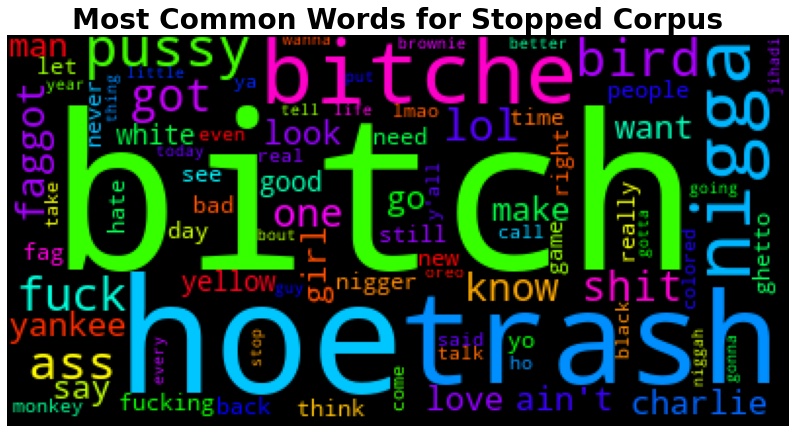

In [25]:
## Create a word cloud visualization of the most frequently used words
 ## in the full corpus
plot_wordcloud(stopped_tokens, 'Stopped Corpus');

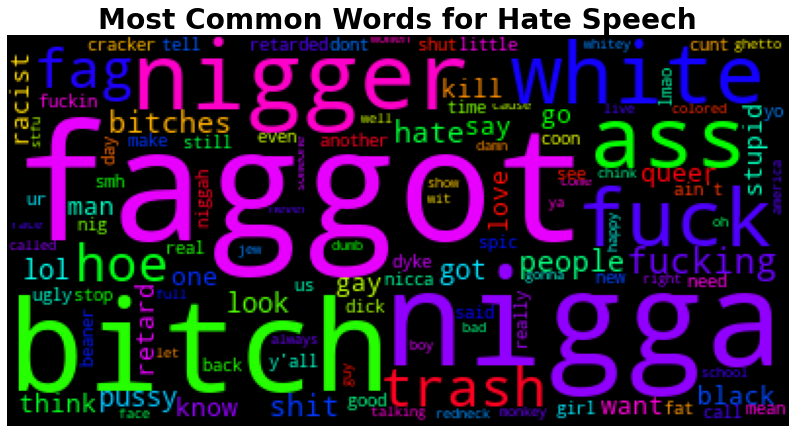

In [29]:
## Create a word cloud visualization of the most frequently used words
 ## in hate speech tweets
plot_wordcloud(hate_tokens, 'Hate Speech');

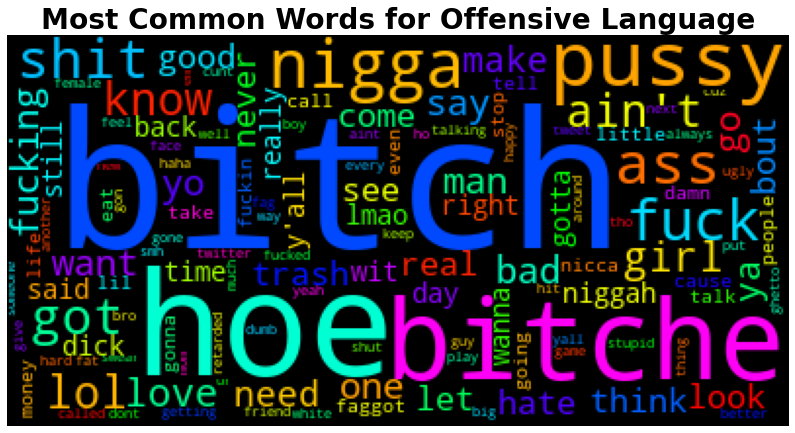

In [30]:
## Create a word cloud visualization of the most frequently used words 
 ## in offensive language tweets
plot_wordcloud(offensive_tokens, 'Offensive Language');

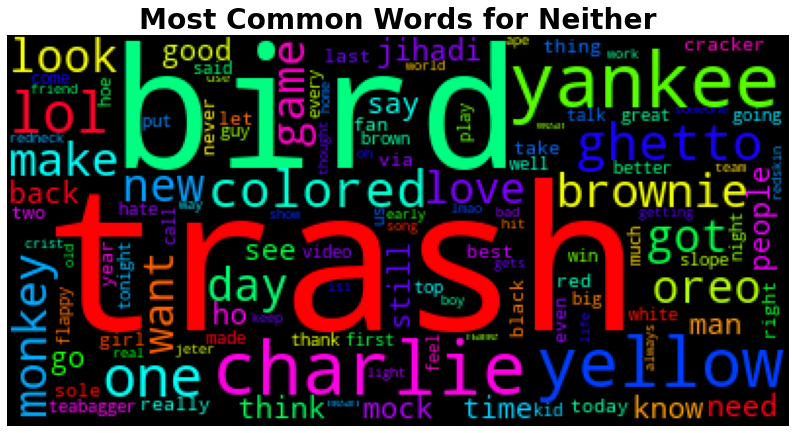

In [31]:
## Create a word cloud visualization of the most frequently used words 
 ## in neither tweets
plot_wordcloud(neither_tokens, 'Neither');

In [32]:
## Create bigrams
bigram_measures = nltk.collocations.BigramAssocMeasures()
tweet_finder = nltk.BigramCollocationFinder.from_words(stopped_tokens)
tweets_scored = tweet_finder.score_ngrams(bigram_measures.raw_freq)

## Make a DataFrame from the bigrams
pd.DataFrame(tweets_scored, columns=['Word', 'Freq']).head(25)

Word      Freq
0        (look, like)  0.001046
1      (white, trash)  0.000980
2        (bitch, ass)  0.000913
3       (like, bitch)  0.000715
4        (ass, nigga)  0.000702
5        (ass, bitch)  0.000688
6        (bad, bitch)  0.000649
7       (fuck, bitch)  0.000635
8      (flappy, bird)  0.000556
9     (little, bitch)  0.000530
10     (bad, bitches)  0.000503
11        (yo, bitch)  0.000503
12      (looks, like)  0.000477
13   (charlie, crist)  0.000450
14     (bitch, ain't)  0.000437
15     (bitch, bitch)  0.000437
16     (bitch, nigga)  0.000437
17       (eat, pussy)  0.000437
18      (bitch, like)  0.000410
19       (feel, like)  0.000410
20   (charlie, sheen)  0.000371
21  (happy, birthday)  0.000344
22       (bitch, got)  0.000331
23    (bitches, like)  0.000331
24   (charlie, brown)  0.000331

In [33]:
## Calculate Pointwise Mutual Information scores
tweet_pmi_finder = nltk.BigramCollocationFinder.from_words(stopped_tokens)
tweet_pmi_finder.apply_freq_filter(5)
tweet_pmi_scored = tweet_pmi_finder.score_ngrams(bigram_measures.pmi)

# Make a DataFrame from the Bigrams with PMI
pd.DataFrame.from_records(tweet_pmi_scored, columns=['Words', 'PMI']).head(25)

Words        PMI
0        (spear, chucker)  13.619972
1     (disrupts, shylock)  13.397579
2   (operation, disrupts)  13.397579
3      (shylock, banking)  13.397579
4           (scally, lad)  12.549582
5            (blah, blah)  12.368433
6            (rated, spa)  11.957007
7        (grand, opening)  11.812617
8           (guinea, pig)  11.812617
9         (catches, worm)  11.771975
10        (porn, android)  11.731003
11         (iphone, ipad)  11.681372
12          (fairy, tale)  11.619972
13           (woof, woof)  11.619972
14               (jay, z)  11.552857
15      (android, iphone)  11.529369
16    (massage, brooklyn)  11.450047
17          (shy, glizzy)  11.450047
18          (rick, scott)  11.397579
19   (international, law)  11.389017
20       (brooklyn, park)  11.346953
21         (planet, apes)  11.280122
22        (social, media)  10.976115
23      (slippery, slope)  10.957007
24         (derek, jeter)  10.919532

# MODEL

## Train Test Split

In [34]:
## Import necessary functions/methods/classes for modeling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from sklearn import metrics

In [35]:
## Make X and y
y = df['class_code'].copy() # target is class code (true label)
X = df['text'].copy() # use tweet text to classify
X_lemma = df['lemma_text'].copy() # also try using a lemmatized version of text

In [36]:
## Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=319)
# setting stratify=y should ensure class imbalances remain similar to original distribution

In [37]:
## Check for class imbalance across all sets of y
print('**original**\n', y.value_counts(normalize=True), '\n------\n')
print('**y_train**\n', y_train.value_counts(normalize=True), '\n------\n')
print('**y_test**\n', y_test.value_counts(normalize=True), '\n------\n')

**original**
 1    0.4407
2    0.4163
0    0.1430
Name: class_code, dtype: float64 
------

**y_train**
 1    0.44075
2    0.41625
0    0.14300
Name: class_code, dtype: float64 
------

**y_test**
 1    0.4405
2    0.4165
0    0.1430
Name: class_code, dtype: float64 
------



In [38]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(8000,) (2000,) (8000,) (2000,)


In [39]:
## Split lemmatized data into training and testing sets
X_lemma_train, X_lemma_test, y_lemma_train, y_lemma_test = train_test_split(X_lemma,
                                                                            y,
                                                                            test_size=0.2,
                                                                            stratify=y,
                                                                            random_state=319)
# setting stratify=y should ensure class imbalances remain similar to original distribution

In [128]:
## Inspect X_train to make sure it is the same exact subset of data as X_lemma_train below
X_train

7332    Damn those shiner rock those bud light platinu...
9652    Video: Charlie Baker makes final push for votes  
1746                                               bitch.
6696      hey I'll leave Abbey too! Oh if I get a job ...
7487              Gone bust it open for a real nicca  ; ;
                              ...                        
586                                      stfu u ugly dyke
64                ; : "fucking white people"   bitch wut?
9729    Whoever made these brownies and cookies belong...
9964    they're not playing Charlie Strong's soft don'...
4312                   You pussy nigga, I see ya whiskers
Name: text, Length: 8000, dtype: object

In [41]:
## Inspect X_lemma_train to make sure it is the same exact subset of data as X_train above
X_lemma_train

7332            damn shiner rock bud light platinum ciroc
9652             video charlie baker make final push vote
1746                                                bitch
6696    hey leave abbey oh get job slope might move ba...
7487                            gone bust open real nicca
                              ...                        
586                                        stfu ugly dyke
64                         fucking white people bitch wut
9729            whoever made brownie cooky belongs heaven
9964    they're playing charlie strong's soft run scor...
4312                           pussy nigga see ya whisker
Name: lemma_text, Length: 8000, dtype: object

## Baseline Models

In [42]:
## Initialize tokenizer to use for base model
tweet_tokenizer = nltk.tokenize.TweetTokenizer(preserve_case=False, reduce_len=True)

## Initialize vectorizers to use for base models
count_vec = CountVectorizer(tokenizer=tweet_tokenizer.tokenize,
                            stop_words=stopwords_list)

tfidf_vec = TfidfVectorizer(tokenizer=tweet_tokenizer.tokenize,
                            stop_words=stopwords_list)

## Vectorize X_train and X_test with each vectorizer
X_train_count_vec = count_vec.fit_transform(X_train)
X_test_count_vec = count_vec.transform(X_test)

X_train_tfidf_vec = tfidf_vec.fit_transform(X_train)
X_test_tfidf_vec = tfidf_vec.transform(X_test)

print(X_train_count_vec.shape, X_test_count_vec.shape)
print(X_train_tfidf_vec.shape, X_test_tfidf_vec.shape)

(8000, 12432) (2000, 12432)
(8000, 12432) (2000, 12432)


### Baseline Random Forest Classifiers

In [43]:
## Build baseline Random Forest Pipelines - 1 with Count Vectorizer, 1 with Tfidf

## Initialize tokenizer
tweet_tokenizer = nltk.tokenize.TweetTokenizer(preserve_case=False, reduce_len=True)

# Build Pipelines for fitting model
rf_cv_pipe = Pipeline(steps=[
                         ('count_vec', CountVectorizer(tokenizer=tweet_tokenizer.tokenize,
                            stop_words=stopwords_list)),
                         ('rf', RandomForestClassifier(random_state=319))
                        ])

rf_tfidf_pipe = Pipeline(steps=[
                         ('tfidf_vec', TfidfVectorizer(tokenizer=tweet_tokenizer.tokenize,
                            stop_words=stopwords_list)),
                         ('rf', RandomForestClassifier(random_state=319))
                        ])

---------------------------------------------------------
Classification Report: Baseline RF with Count Vectorizer
---------------------------------------------------------
              precision    recall  f1-score   support

 Hate Speech       0.69      0.53      0.60       286
   Offensive       0.85      0.90      0.88       881
     Neither       0.92      0.94      0.93       833

    accuracy                           0.86      2000
   macro avg       0.82      0.79      0.80      2000
weighted avg       0.86      0.86      0.86      2000

---------------------------------------------------------
---------------------------------------------------------




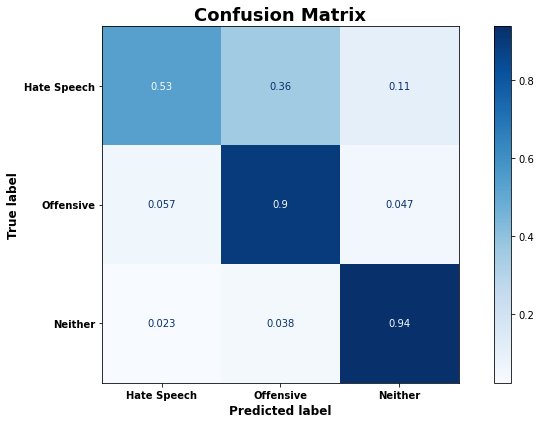

In [44]:
## Fit and evaluate baseline RF with Count Vectorizer
rf_cv_pipe.fit(X_train, y_train)
eval_classifier(rf_cv_pipe, X_test, y_test, model_descr='Baseline RF with Count Vectorizer');

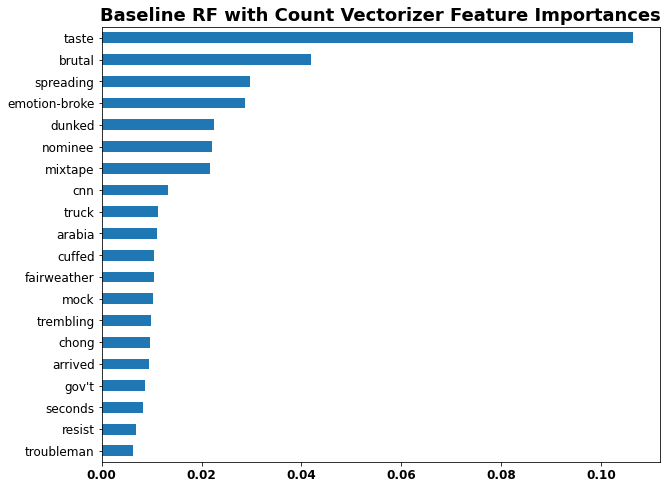

In [45]:
## Plot top 20 most important words for model predictions and their weights
plot_feat_importance(rf_cv_pipe, 'rf', 'count_vec', 'Baseline RF with Count Vectorizer');

----------------------------------------------------------
Classification Report: Baseline RF with TF-IDF Vectorizer
----------------------------------------------------------
              precision    recall  f1-score   support

 Hate Speech       0.77      0.49      0.60       286
   Offensive       0.85      0.91      0.88       881
     Neither       0.91      0.95      0.93       833

    accuracy                           0.87      2000
   macro avg       0.84      0.78      0.80      2000
weighted avg       0.86      0.87      0.86      2000

----------------------------------------------------------
----------------------------------------------------------




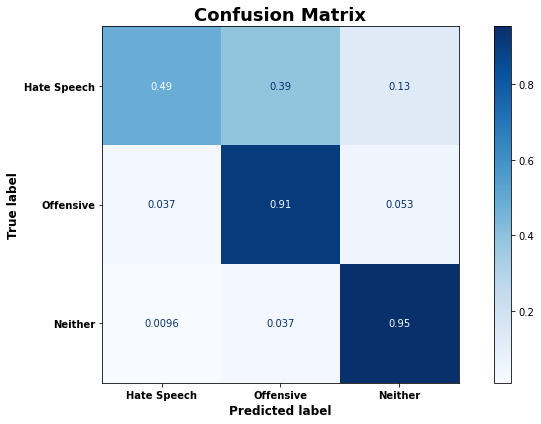

In [46]:
## Fit and evaluate baseline RF with TF-IDF Vectorizer
rf_tfidf_pipe.fit(X_train, y_train)
eval_classifier(rf_tfidf_pipe, X_test, y_test, model_descr='Baseline RF with TF-IDF Vectorizer');

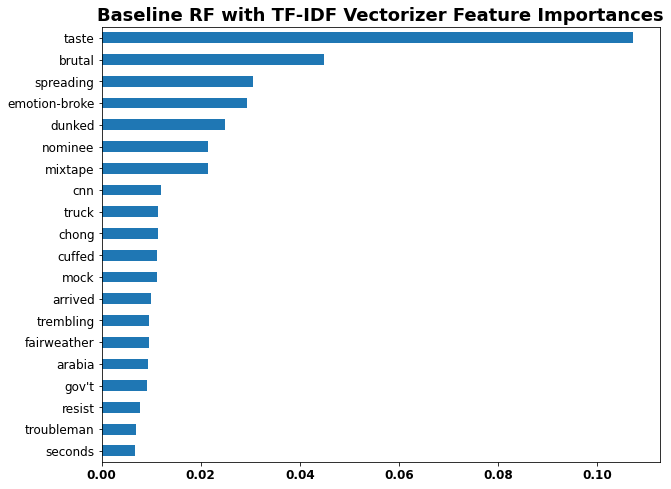

In [47]:
## Plot top 20 most important words for model predictions and their weights
plot_feat_importance(rf_tfidf_pipe, 'rf', 'tfidf_vec', 'Baseline RF with TF-IDF Vectorizer');

### Baseline Multinomial Naive Bayes Classifiers

In [48]:
# Build baseline Multinomial Naive Bayes Pipelines - 1 with Count Vectorizer, 1 with Tfidf

## Initialize tokenizer
tweet_tokenizer = nltk.tokenize.TweetTokenizer(preserve_case=False, reduce_len=True)

# Build Pipelines for fitting model
mnb_cv_pipe = Pipeline(steps=[
                         ('count_vec', CountVectorizer(tokenizer=tweet_tokenizer.tokenize,
                            stop_words=stopwords_list)),
                         ('mnb', MultinomialNB())
                        ])

mnb_tfidf_pipe = Pipeline(steps=[
                         ('tfidf_vec', TfidfVectorizer(tokenizer=tweet_tokenizer.tokenize,
                            stop_words=stopwords_list)),
                         ('mnb', MultinomialNB())
                        ])

----------------------------------------------------------
Classification Report: Baseline MNB with Count Vectorizer
----------------------------------------------------------
              precision    recall  f1-score   support

 Hate Speech       0.73      0.31      0.44       286
   Offensive       0.78      0.95      0.85       881
     Neither       0.91      0.88      0.89       833

    accuracy                           0.83      2000
   macro avg       0.81      0.71      0.73      2000
weighted avg       0.83      0.83      0.81      2000

----------------------------------------------------------
----------------------------------------------------------




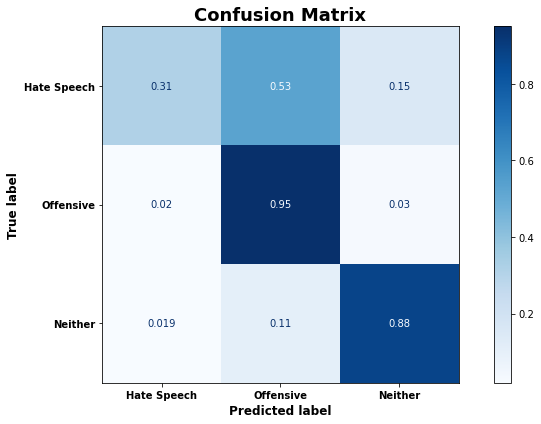

In [49]:
## Fit and evaluate baseline MNB with Count Vectorizer
mnb_cv_pipe.fit(X_train, y_train)
eval_classifier(mnb_cv_pipe, X_test, y_test, model_descr='Baseline MNB with Count Vectorizer');

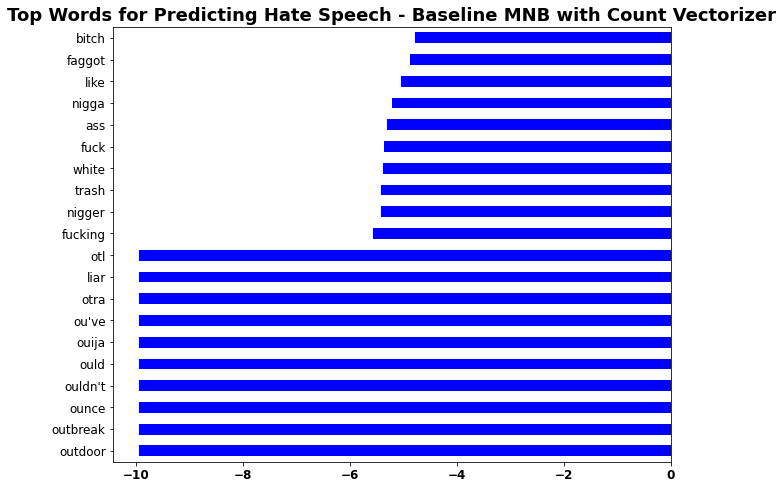

In [50]:
## Plot top 20 most important words for predicting hate speech and their weights
plot_coefficients(mnb_cv_pipe, 'mnb', 'count_vec', 0, 'Baseline MNB with Count Vectorizer');

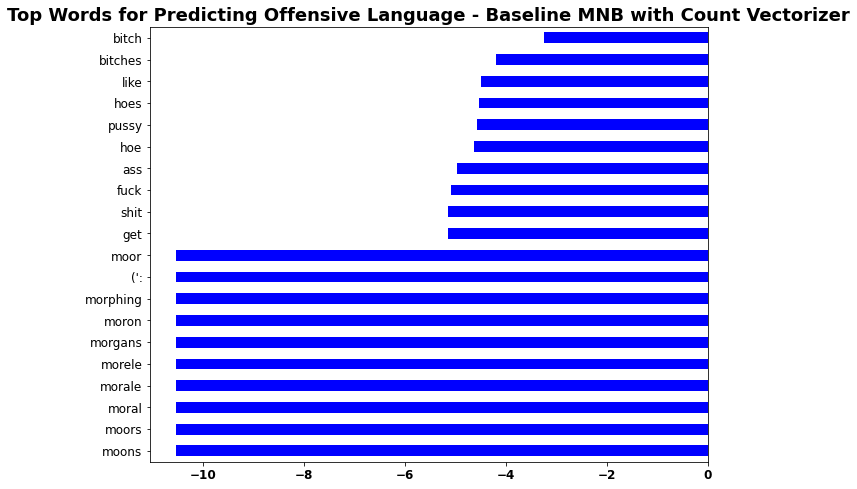

In [51]:
## Plot top 20 most important words for predicting offenisve language and their weights
plot_coefficients(mnb_cv_pipe, 'mnb', 'count_vec', 1, 'Baseline MNB with Count Vectorizer');

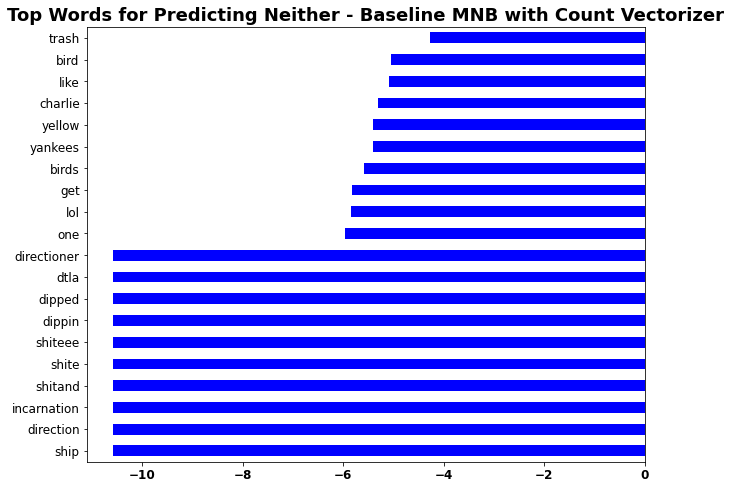

In [52]:
## Plot top 20 most important words for predicting neither and their weights
plot_coefficients(mnb_cv_pipe, 'mnb', 'count_vec', 2, 'Baseline MNB with Count Vectorizer');

-----------------------------------------------------------
Classification Report: Baseline MNB with TF-IDF Vectorizer
-----------------------------------------------------------
              precision    recall  f1-score   support

 Hate Speech       0.89      0.06      0.11       286
   Offensive       0.70      0.97      0.81       881
     Neither       0.90      0.83      0.86       833

    accuracy                           0.78      2000
   macro avg       0.83      0.62      0.59      2000
weighted avg       0.81      0.78      0.73      2000

-----------------------------------------------------------
-----------------------------------------------------------




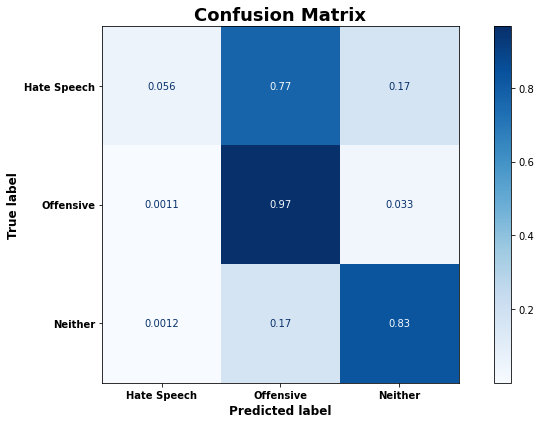

In [53]:
## Fit and evaluate baseline MNB with Count Vectorizer
mnb_tfidf_pipe.fit(X_train, y_train)
eval_classifier(mnb_tfidf_pipe, X_test, y_test, model_descr='Baseline MNB with TF-IDF Vectorizer');

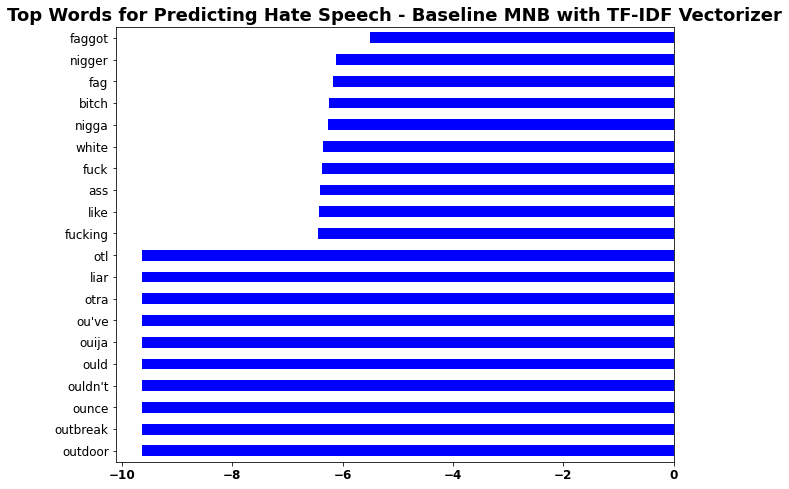

In [54]:
## Plot top 20 most important words for predicting hate speech and their weights
plot_coefficients(mnb_tfidf_pipe, 'mnb', 'tfidf_vec', 0, 'Baseline MNB with TF-IDF Vectorizer');

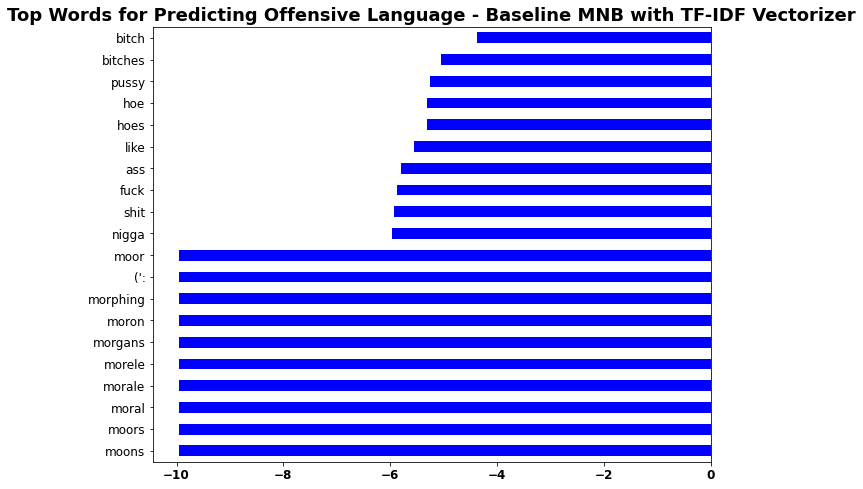

In [55]:
## Plot top 20 most important words for predicting offensive language and their weights
plot_coefficients(mnb_tfidf_pipe, 'mnb', 'tfidf_vec', 1, 'Baseline MNB with TF-IDF Vectorizer');

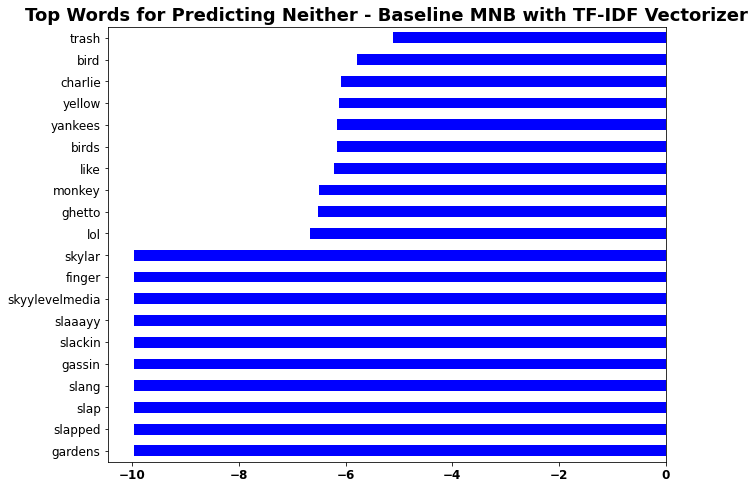

In [56]:
## Plot top 20 most important words for predicting neither and their weights
plot_coefficients(mnb_tfidf_pipe, 'mnb', 'tfidf_vec', 2, 'Baseline MNB with TF-IDF Vectorizer');

### Baseline LinearSVC Classifiers

In [57]:
# Build baseline LinearSVC Pipelines - 1 with Count Vectorizer, 1 with Tfidf

## Initialize tokenizer
tweet_tokenizer = nltk.tokenize.TweetTokenizer(preserve_case=False, reduce_len=True)

# Build Pipelines for fitting model
svc_cv_pipe = Pipeline(steps=[
                         ('count_vec', CountVectorizer(tokenizer=tweet_tokenizer.tokenize,
                            stop_words=stopwords_list)),
                         ('svc', LinearSVC(random_state=319))
                        ])

svc_tfidf_pipe = Pipeline(steps=[
                         ('tfidf_vec', TfidfVectorizer(tokenizer=tweet_tokenizer.tokenize,
                            stop_words=stopwords_list)),
                         ('svc', LinearSVC(random_state=319))
                        ])

----------------------------------------------------------------
Classification Report: Baseline LinearSVC with Count Vectorizer
----------------------------------------------------------------
              precision    recall  f1-score   support

 Hate Speech       0.60      0.57      0.59       286
   Offensive       0.84      0.87      0.85       881
     Neither       0.92      0.91      0.91       833

    accuracy                           0.84      2000
   macro avg       0.79      0.78      0.78      2000
weighted avg       0.84      0.84      0.84      2000

----------------------------------------------------------------
----------------------------------------------------------------




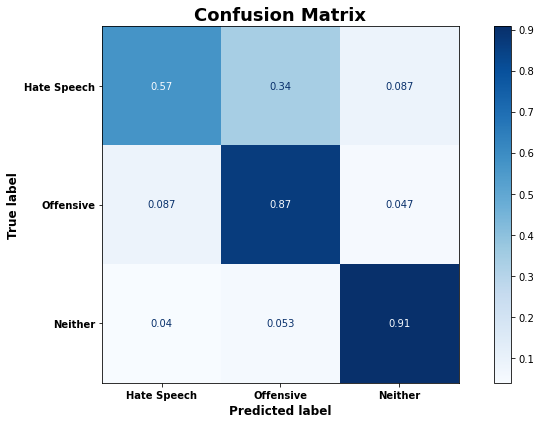

In [58]:
## Fit and evaluate baseline LinearSVC with Count Vectorizer
svc_cv_pipe.fit(X_train, y_train)
eval_classifier(svc_cv_pipe, X_test, y_test, model_descr='Baseline LinearSVC with Count Vectorizer');

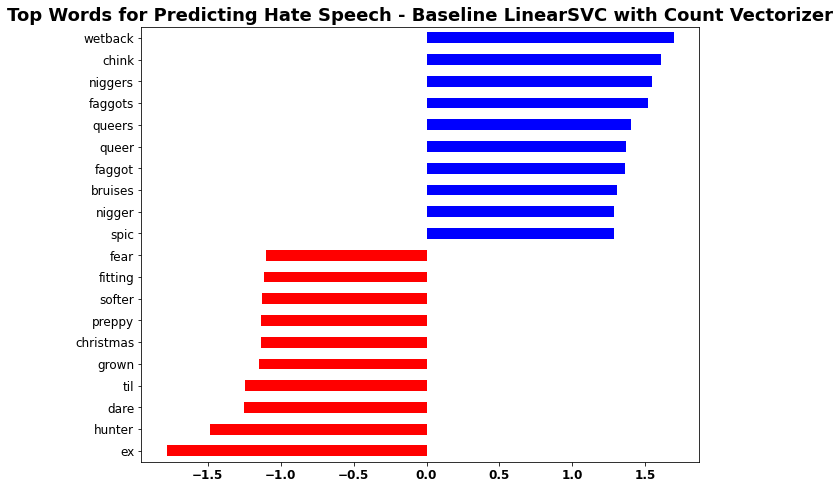

In [59]:
## Plot top 20 most important words for predicting hate speech and their weights
plot_coefficients(svc_cv_pipe, 'svc', 'count_vec', 0, 'Baseline LinearSVC with Count Vectorizer');

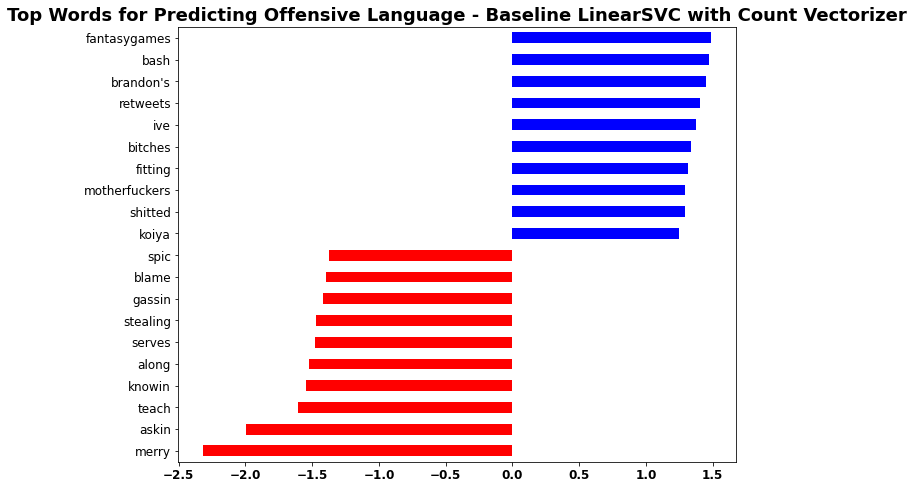

In [60]:
## Plot top 20 most important words for predicting offensive language and their weights
plot_coefficients(svc_cv_pipe, 'svc', 'count_vec', 1, 'Baseline LinearSVC with Count Vectorizer');

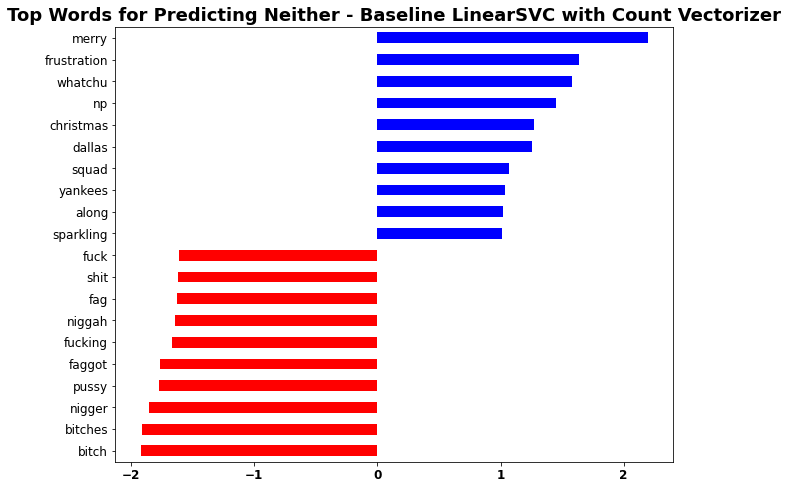

In [61]:
## Plot top 20 most important words for predicting neither and their weights
plot_coefficients(svc_cv_pipe, 'svc', 'count_vec', 2, 'Baseline LinearSVC with Count Vectorizer');

-----------------------------------------------------------------
Classification Report: Baseline LinearSVC with TF-IDF Vectorizer
-----------------------------------------------------------------
              precision    recall  f1-score   support

 Hate Speech       0.70      0.55      0.61       286
   Offensive       0.86      0.89      0.87       881
     Neither       0.90      0.94      0.92       833

    accuracy                           0.86      2000
   macro avg       0.82      0.79      0.80      2000
weighted avg       0.85      0.86      0.85      2000

-----------------------------------------------------------------
-----------------------------------------------------------------




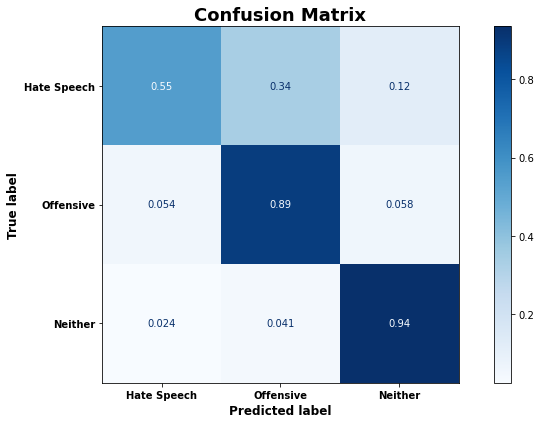

In [62]:
## Fit and evaluate baseline LinearSVC with Count Vectorizer
svc_tfidf_pipe.fit(X_train, y_train)
eval_classifier(svc_tfidf_pipe, X_test, y_test, model_descr='Baseline LinearSVC with TF-IDF Vectorizer');

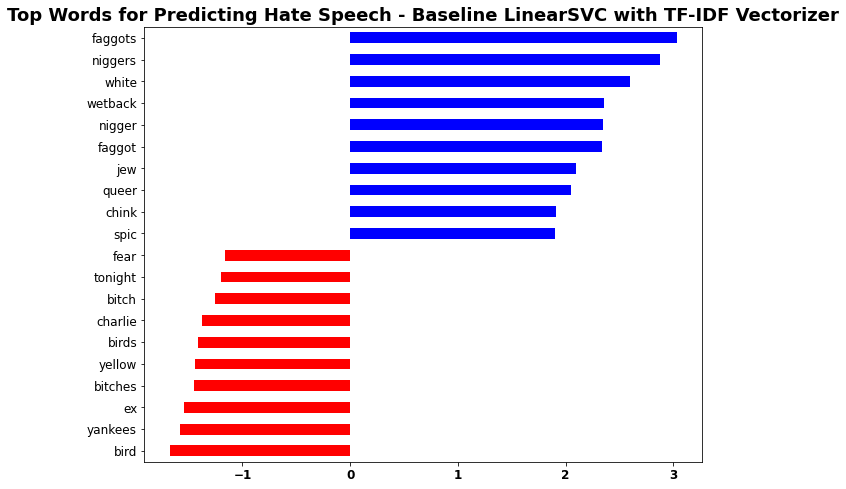

In [63]:
## Plot top 20 most important words for predicting hate speech and their weights
plot_coefficients(svc_tfidf_pipe, 'svc', 'tfidf_vec', 0, 'Baseline LinearSVC with TF-IDF Vectorizer');

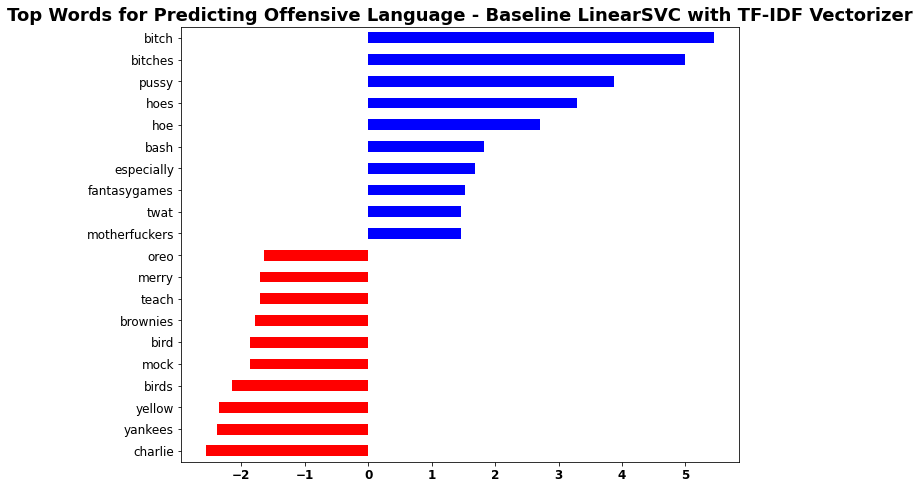

In [64]:
## Plot top 20 most important words for predicting offensive language and their weights
plot_coefficients(svc_tfidf_pipe, 'svc', 'tfidf_vec', 1, 'Baseline LinearSVC with TF-IDF Vectorizer');

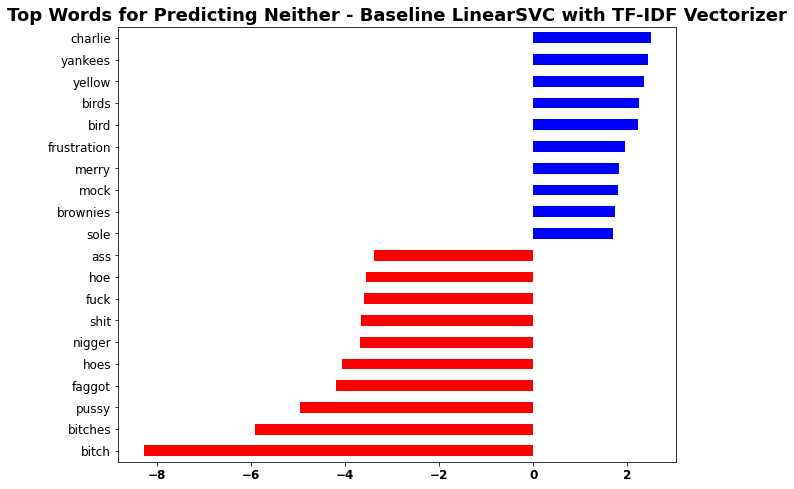

In [65]:
## Plot top 20 most important words for predicting neither and their weights
plot_coefficients(svc_tfidf_pipe, 'svc', 'tfidf_vec', 2, 'Baseline LinearSVC with TF-IDF Vectorizer');

### Baseline XGB Classifiers

In [66]:
## Build baseline XGBoost Pipelines - 1 with Count Vectorizer, 1 with Tfidf

## Initialize tokenizer
tweet_tokenizer = nltk.tokenize.TweetTokenizer(preserve_case=False, reduce_len=True)

# Build Pipelines for fitting model
xgb_cv_pipe = Pipeline(steps=[
                         ('count_vec', CountVectorizer(tokenizer=tweet_tokenizer.tokenize,
                            stop_words=stopwords_list)),
                         ('svd', TruncatedSVD(n_components=150, random_state=319)),
                         ('xgb', XGBClassifier(random_state=319, n_jobs=-1))
                        ])

xgb_tfidf_pipe = Pipeline(steps=[
                         ('tfidf_vec', TfidfVectorizer(tokenizer=tweet_tokenizer.tokenize,
                            stop_words=stopwords_list)),
                         ('svd', TruncatedSVD(n_components=150, random_state=319)),
                         ('xgb', XGBClassifier(random_state=319, n_jobs=-1))
                        ])

----------------------------------------------------------
Classification Report: Baseline XGB with Count Vectorizer
----------------------------------------------------------
              precision    recall  f1-score   support

 Hate Speech       0.73      0.36      0.48       286
   Offensive       0.87      0.86      0.87       881
     Neither       0.82      0.97      0.89       833

    accuracy                           0.83      2000
   macro avg       0.81      0.73      0.75      2000
weighted avg       0.83      0.83      0.82      2000

----------------------------------------------------------
----------------------------------------------------------




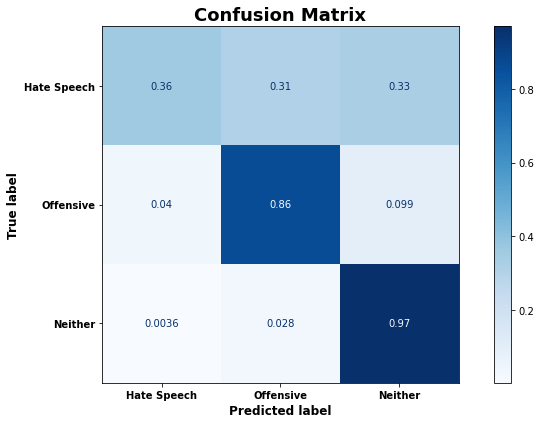

In [67]:
## Fit and evaluate baseline XGB with Count Vectorizer
xgb_cv_pipe.fit(X_train, y_train)
eval_classifier(xgb_cv_pipe, X_test, y_test, model_descr='Baseline XGB with Count Vectorizer');

-----------------------------------------------------------
Classification Report: Baseline XGB with TF-IDF Vectorizer
-----------------------------------------------------------
              precision    recall  f1-score   support

 Hate Speech       0.71      0.42      0.53       286
   Offensive       0.87      0.88      0.87       881
     Neither       0.85      0.96      0.90       833

    accuracy                           0.84      2000
   macro avg       0.81      0.75      0.77      2000
weighted avg       0.84      0.84      0.83      2000

-----------------------------------------------------------
-----------------------------------------------------------




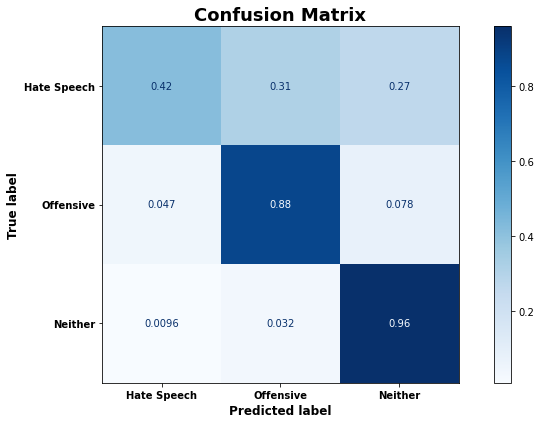

In [69]:
## Fit and evaluate baseline XGB with TF-IDF Vectorizer
xgb_tfidf_pipe.fit(X_train, y_train)
eval_classifier(xgb_tfidf_pipe, X_test, y_test, model_descr='Baseline XGB with TF-IDF Vectorizer');

## Hyperparameter Tuning for Random Forest Classifiers

### Tuning Count Vectorizer Random Forests

------------------------------------------------------------
***** Grid Search Started at 10/30/20 - 18:51:34 PM
------------------------------------------------------------


***** Training Completed at 10/30/20 - 18:52:27 PM

***** Total Training Time: 0:00:52.753308


Best Parameters:
{'count_vec__min_df': 2, 'count_vec__ngram_range': (1, 2), 'rf__class_weight': 'balanced', 'rf__criterion': 'gini', 'rf__max_depth': None}


-------------------------------------------------------------------
Classification Report: Best Count Vectorizer RF Tuned for Accuracy
-------------------------------------------------------------------
              precision    recall  f1-score   support

 Hate Speech       0.68      0.57      0.62       286
   Offensive       0.87      0.89      0.88       881
     Neither       0.92      0.94      0.93       833

    accuracy                           0.87      2000
   macro avg       0.82      0.80      0.81      2000
weighted avg       0.86      0.87      0.

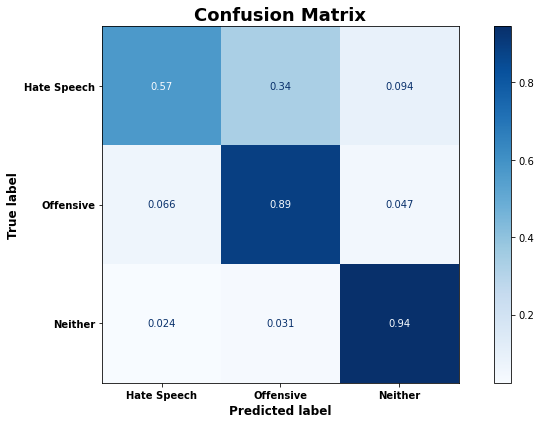

In [70]:
## define a grid of different hyperparameter values to be tested
params = {'count_vec__ngram_range':[(1,1),(1,2)],
          'count_vec__min_df':[0.005, 2],
          'rf__criterion':['gini', 'entropy'],
          'rf__max_depth':[None, 3, 6],
          'rf__class_weight':[None, 'balanced']
         }

## run the grid search to test parameters and find the best estimator 
rf_cv_acc_grid = fit_grid_clf(rf_cv_pipe, params, 
                       X_train, y_train,
                       X_test, y_test,
                       model_descr='Best Count Vectorizer RF Tuned for Accuracy',
                       score='accuracy')

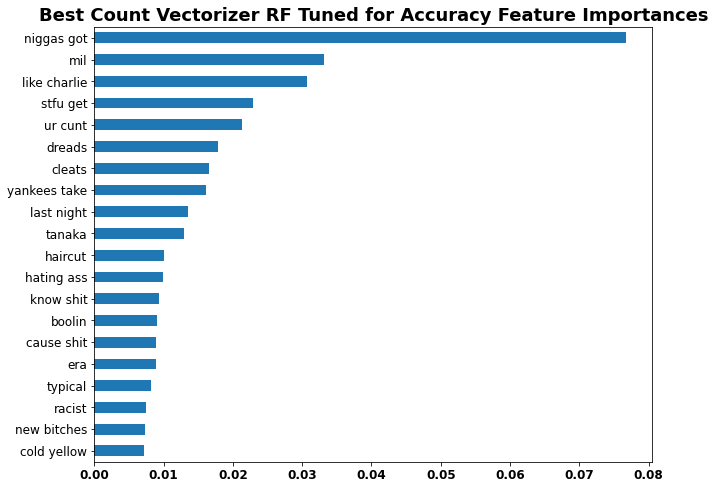

In [71]:
## Plot top 20 most important words for model predictions and their weights
plot_feat_importance(rf_cv_acc_grid.best_estimator_, 'rf', 'count_vec',
                     'Best Count Vectorizer RF Tuned for Accuracy');

------------------------------------------------------------
***** Grid Search Started at 10/30/20 - 18:52:28 PM
------------------------------------------------------------


***** Training Completed at 10/30/20 - 18:53:19 PM

***** Total Training Time: 0:00:50.748667


Best Parameters:
{'count_vec__min_df': 2, 'count_vec__ngram_range': (1, 2), 'rf__class_weight': 'balanced', 'rf__criterion': 'gini', 'rf__max_depth': None}


----------------------------------------------------------------------------
Classification Report: Best Count Vectorizer RF Tuned for Balanced Accuracy
----------------------------------------------------------------------------
              precision    recall  f1-score   support

 Hate Speech       0.68      0.57      0.62       286
   Offensive       0.87      0.89      0.88       881
     Neither       0.92      0.94      0.93       833

    accuracy                           0.87      2000
   macro avg       0.82      0.80      0.81      2000
weighted avg  

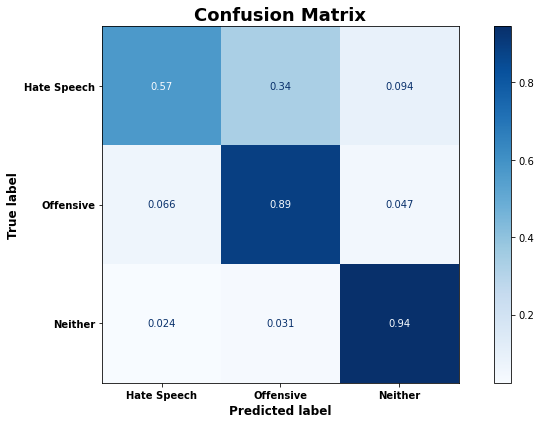

In [72]:
## define a grid of different hyperparameter values to be tested
params = {'count_vec__ngram_range':[(1,1),(1,2)],
          'count_vec__min_df':[0.005, 2],
          'rf__criterion':['gini', 'entropy'],
          'rf__max_depth':[None, 3, 6],
          'rf__class_weight':[None, 'balanced']
         }

## run the grid search to test parameters and find the best estimator 
rf_cv_bacc_grid = fit_grid_clf(rf_cv_pipe, params, 
                       X_train, y_train,
                       X_test, y_test,
                       model_descr='Best Count Vectorizer RF Tuned for Balanced Accuracy',
                       score='balanced_accuracy')

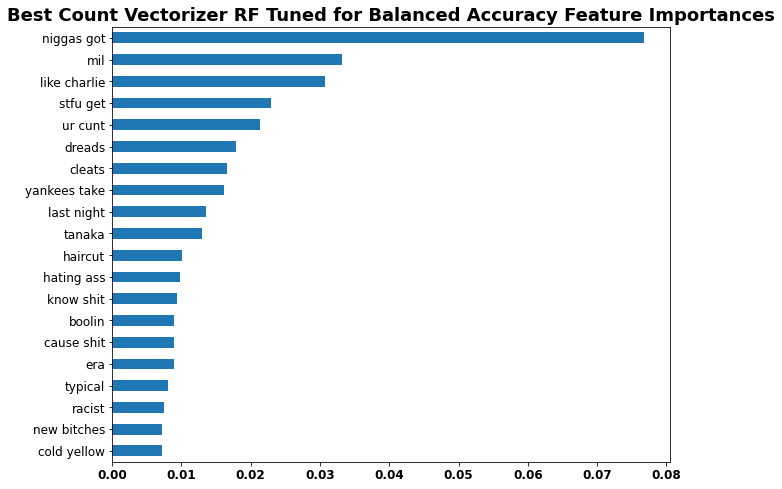

In [73]:
## Plot top 20 most important words for model predictions and their weights
plot_feat_importance(rf_cv_bacc_grid.best_estimator_, 'rf', 'count_vec',
                     'Best Count Vectorizer RF Tuned for Balanced Accuracy');

### Tuning TF-IDF Vectorizer Random Forests

------------------------------------------------------------
***** Grid Search Started at 10/30/20 - 18:53:20 PM
------------------------------------------------------------


***** Training Completed at 10/30/20 - 18:54:07 PM

***** Total Training Time: 0:00:47.374368


Best Parameters:
{'rf__class_weight': 'balanced', 'rf__criterion': 'entropy', 'rf__max_depth': None, 'tfidf_vec__min_df': 2, 'tfidf_vec__ngram_range': (1, 2)}


---------------------------------------------------------
Classification Report: Best TF-IDF RF Tuned for Accuracy
---------------------------------------------------------
              precision    recall  f1-score   support

 Hate Speech       0.76      0.49      0.60       286
   Offensive       0.86      0.91      0.88       881
     Neither       0.90      0.96      0.93       833

    accuracy                           0.87      2000
   macro avg       0.84      0.79      0.80      2000
weighted avg       0.86      0.87      0.86      2000

-------------

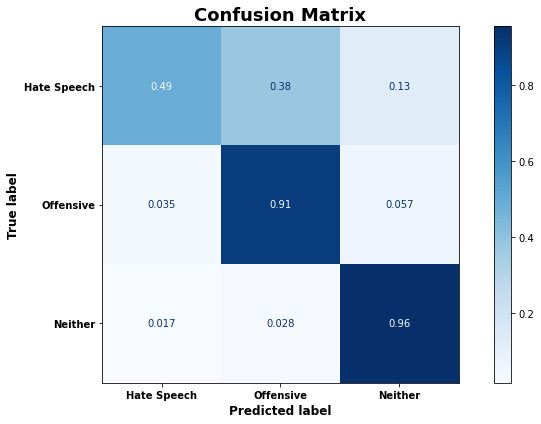

In [74]:
## define a grid of different hyperparameter values to be tested
params = {'tfidf_vec__ngram_range':[(1,1),(1,2)],
          'tfidf_vec__min_df':[0.005, 2],
          'rf__criterion':['gini', 'entropy'],
          'rf__max_depth':[None, 3, 6],
          'rf__class_weight':[None, 'balanced']
         }

## run the grid search to test parameters and find the best estimator 
rf_tfidf_acc_grid = fit_grid_clf(rf_tfidf_pipe, params, 
                       X_train, y_train,
                       X_test, y_test,
                       model_descr='Best TF-IDF RF Tuned for Accuracy',
                       score='accuracy')

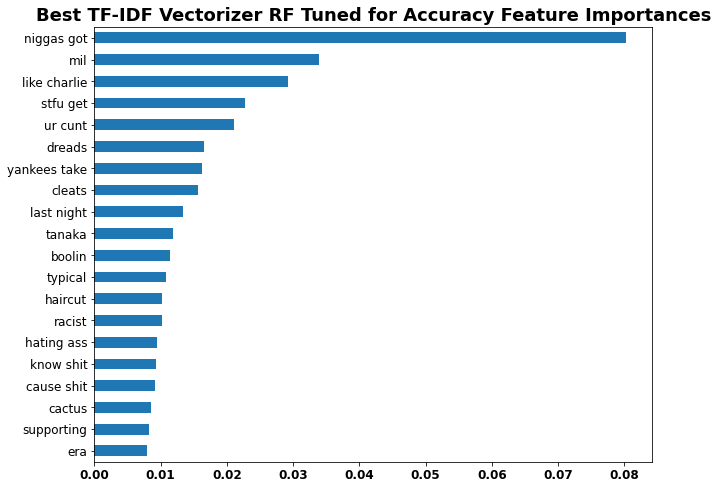

In [75]:
## Plot top 20 most important words for model predictions and their weights
plot_feat_importance(rf_tfidf_acc_grid.best_estimator_, 'rf', 'tfidf_vec',
                     'Best TF-IDF Vectorizer RF Tuned for Accuracy');

------------------------------------------------------------
***** Grid Search Started at 10/30/20 - 18:54:08 PM
------------------------------------------------------------


***** Training Completed at 10/30/20 - 18:54:55 PM

***** Total Training Time: 0:00:47.046310


Best Parameters:
{'rf__class_weight': 'balanced', 'rf__criterion': 'gini', 'rf__max_depth': None, 'tfidf_vec__min_df': 2, 'tfidf_vec__ngram_range': (1, 2)}


------------------------------------------------------------------
Classification Report: Best TF-IDF RF Tuned for Balanced Accuracy
------------------------------------------------------------------
              precision    recall  f1-score   support

 Hate Speech       0.73      0.50      0.60       286
   Offensive       0.86      0.90      0.88       881
     Neither       0.91      0.95      0.93       833

    accuracy                           0.87      2000
   macro avg       0.83      0.79      0.80      2000
weighted avg       0.86      0.87      0.86 

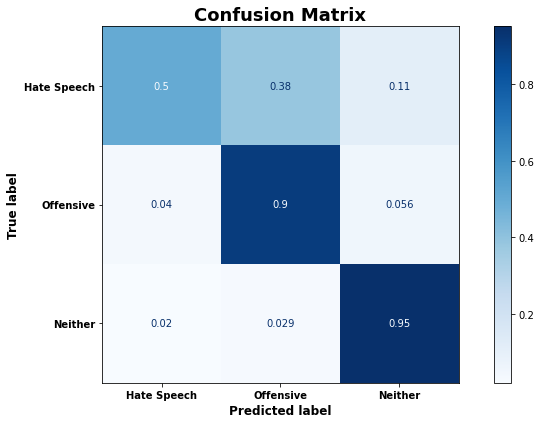

In [76]:
## define a grid of different hyperparameter values to be tested
params = {'tfidf_vec__ngram_range':[(1,1),(1,2)],
          'tfidf_vec__min_df':[0.005, 2],
          'rf__criterion':['gini', 'entropy'],
          'rf__max_depth':[None, 3, 6],
          'rf__class_weight':[None, 'balanced']
         }

## run the grid search to test parameters and find the best estimator 
rf_tfidf_bacc_grid = fit_grid_clf(rf_tfidf_pipe, params, 
                       X_train, y_train,
                       X_test, y_test,
                       model_descr='Best TF-IDF RF Tuned for Balanced Accuracy',
                       score='balanced_accuracy')

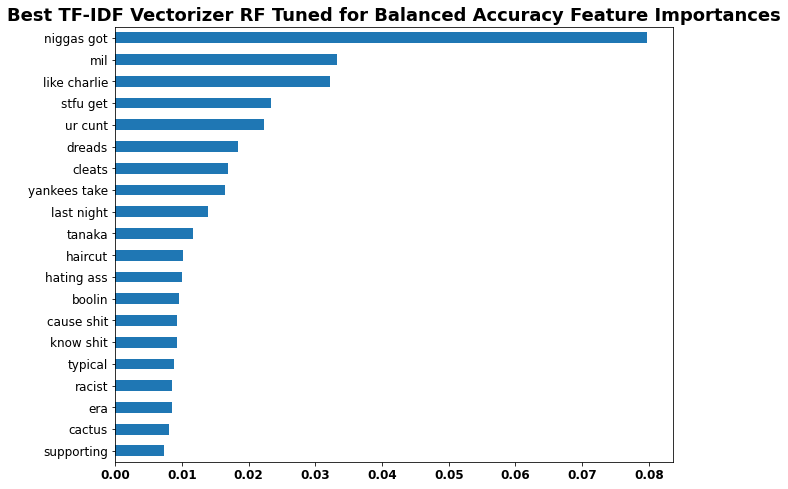

In [77]:
## Plot top 20 most important words for model predictions and their weights
plot_feat_importance(rf_tfidf_bacc_grid.best_estimator_, 'rf', 'tfidf_vec',
                     'Best TF-IDF Vectorizer RF Tuned for Balanced Accuracy');

> - The baseline Random Forest Classifiers seemed to be giving the greatest weight (higher feature importance) to fairly random words. However, with some tuning, the models give more weight to words and bigrams that are more clearly identifiable as offensive (curse words and various slang terms).

## Hyperparameter Tuning for Multinomial Naive Bayes Classifiers

### Tuning Count Vectorizer MNB Models

------------------------------------------------------------
***** Grid Search Started at 10/30/20 - 18:54:56 PM
------------------------------------------------------------


***** Training Completed at 10/30/20 - 18:55:08 PM

***** Total Training Time: 0:00:12.455539


Best Parameters:
{'count_vec__min_df': 2, 'count_vec__ngram_range': (1, 3), 'mnb__alpha': 1.0}


--------------------------------------------------------------------
Classification Report: Best Count Vectorizer MNB Tuned for Accuracy
--------------------------------------------------------------------
              precision    recall  f1-score   support

 Hate Speech       0.68      0.44      0.53       286
   Offensive       0.80      0.92      0.86       881
     Neither       0.92      0.89      0.91       833

    accuracy                           0.84      2000
   macro avg       0.80      0.75      0.77      2000
weighted avg       0.83      0.84      0.83      2000

--------------------------------------------

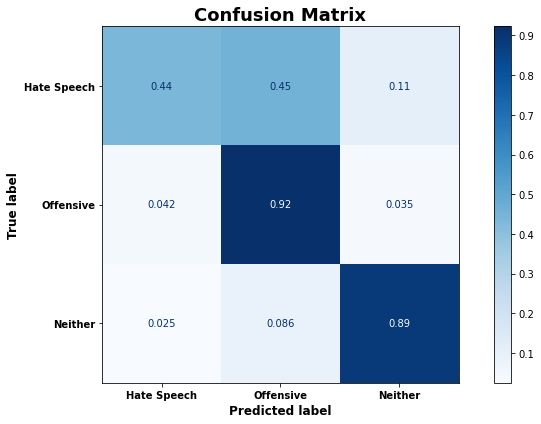

In [78]:
## define a grid of different hyperparameter values to be tested
params = {'count_vec__ngram_range':[(1,1),(1,2),(1,3)],
          'count_vec__min_df':[0.005, 2, 3],
          'mnb__alpha':[1.0, 1e-1, 1e-2]
         }

## run the grid search to test parameters and find the best estimator 
mnb_cv_acc_grid = fit_grid_clf(mnb_cv_pipe, params, 
                       X_train, y_train,
                       X_test, y_test,
                       model_descr='Best Count Vectorizer MNB Tuned for Accuracy',
                       score='accuracy')

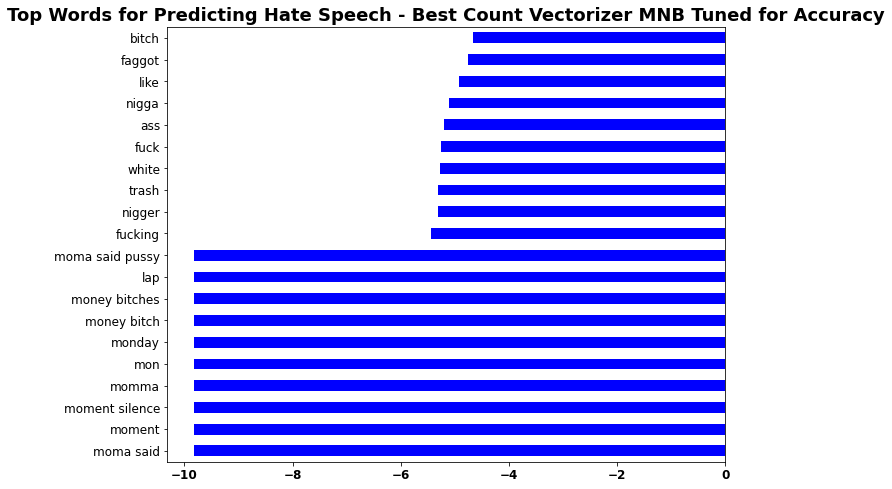

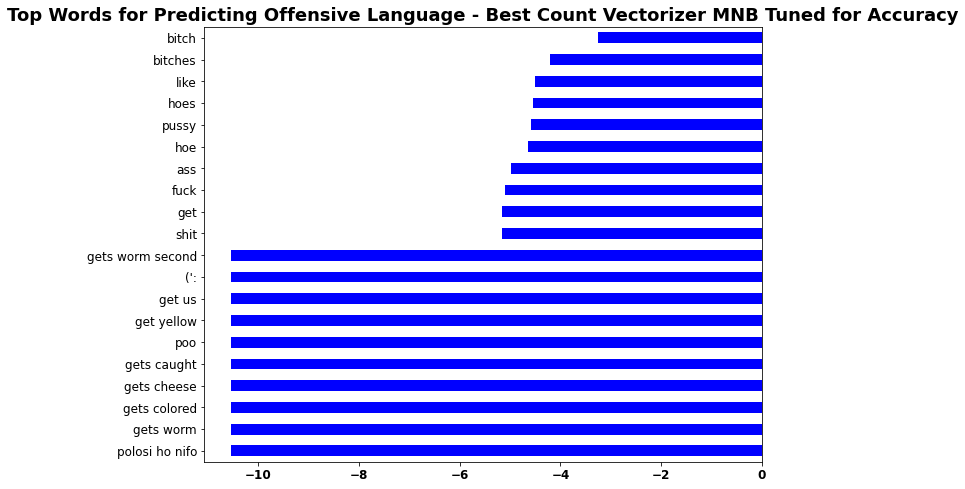

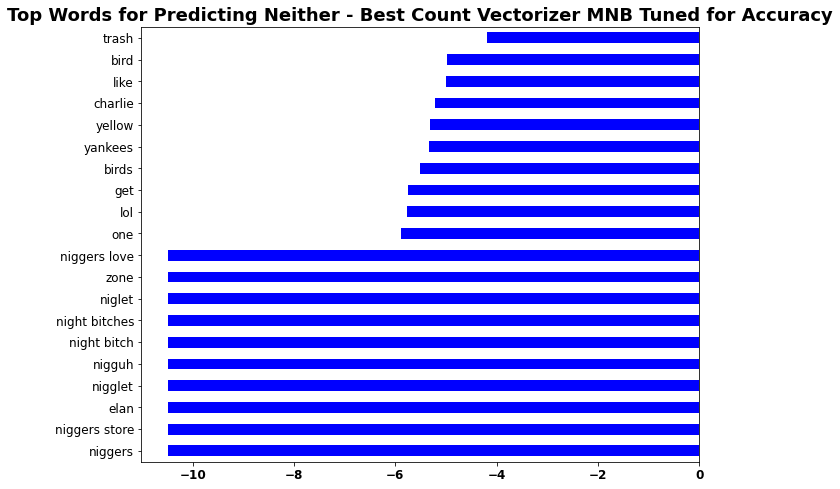

In [79]:
## Plot top 20 most important words for predicting each class and their weights
for i in range(0,3):
    plot_coefficients(mnb_cv_acc_grid.best_estimator_, 'mnb', 'count_vec', i,
                      'Best Count Vectorizer MNB Tuned for Accuracy')

------------------------------------------------------------
***** Grid Search Started at 10/30/20 - 18:55:10 PM
------------------------------------------------------------


***** Training Completed at 10/30/20 - 18:55:23 PM

***** Total Training Time: 0:00:12.927329


Best Parameters:
{'count_vec__min_df': 3, 'count_vec__ngram_range': (1, 3), 'mnb__alpha': 1.0}


-----------------------------------------------------------------------------
Classification Report: Best Count Vectorizer MNB Tuned for Balanced Accuracy
-----------------------------------------------------------------------------
              precision    recall  f1-score   support

 Hate Speech       0.64      0.47      0.54       286
   Offensive       0.80      0.91      0.85       881
     Neither       0.93      0.88      0.91       833

    accuracy                           0.84      2000
   macro avg       0.79      0.75      0.77      2000
weighted avg       0.83      0.84      0.83      2000

-----------------

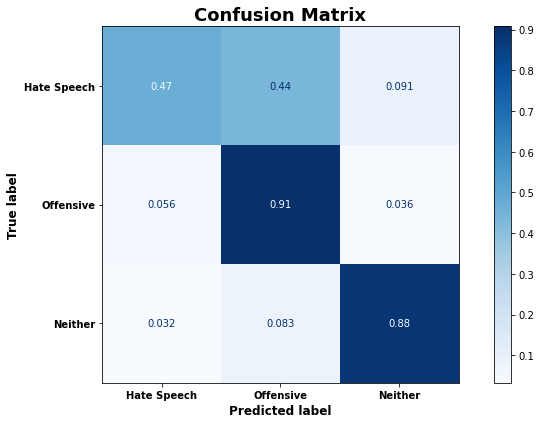

In [80]:
## define a grid of different hyperparameter values to be tested
params = {'count_vec__ngram_range':[(1,1),(1,2),(1,3)],
          'count_vec__min_df':[0.005, 2, 3],
          'mnb__alpha':[1.0, 1e-1, 1e-2]
         }

## run the grid search to test parameters and find the best estimator 
mnb_cv_bacc_grid = fit_grid_clf(mnb_cv_pipe, params, 
                       X_train, y_train,
                       X_test, y_test,
                       model_descr='Best Count Vectorizer MNB Tuned for Balanced Accuracy',
                       score='balanced_accuracy')

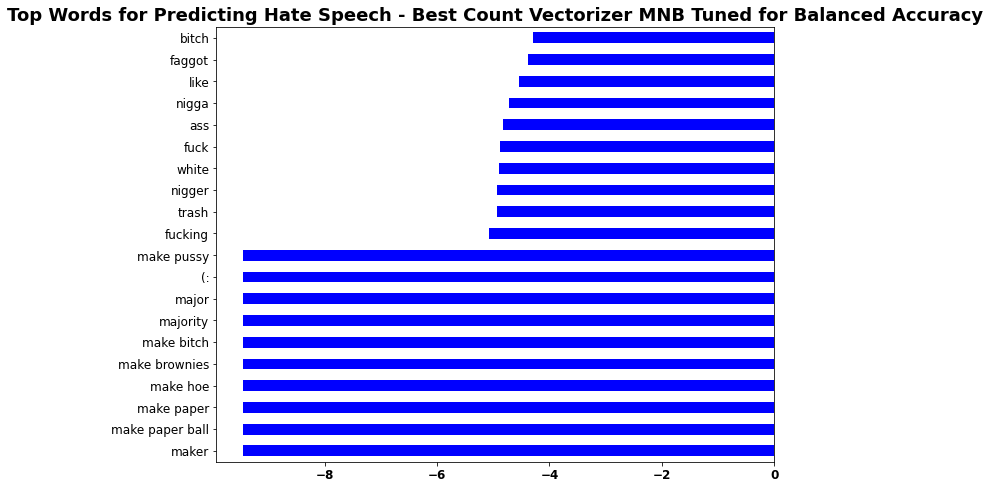

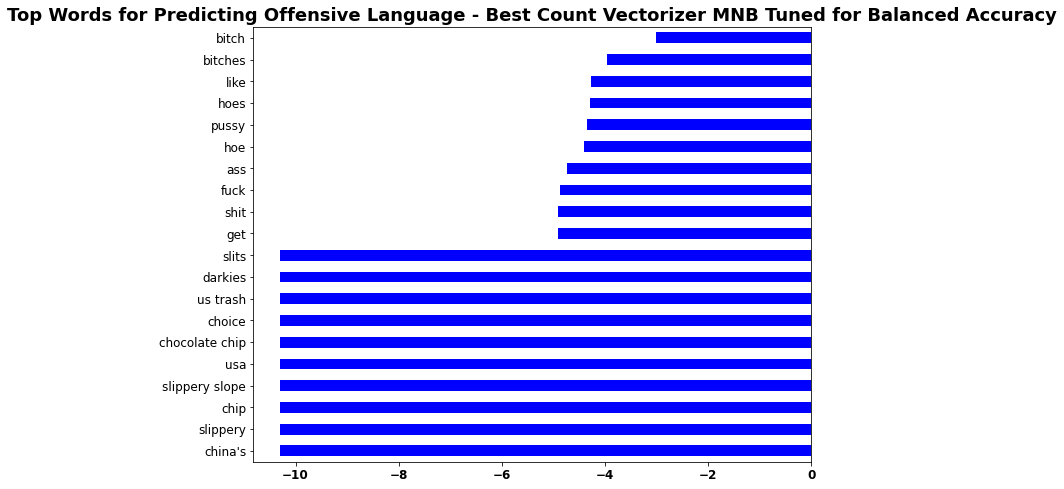

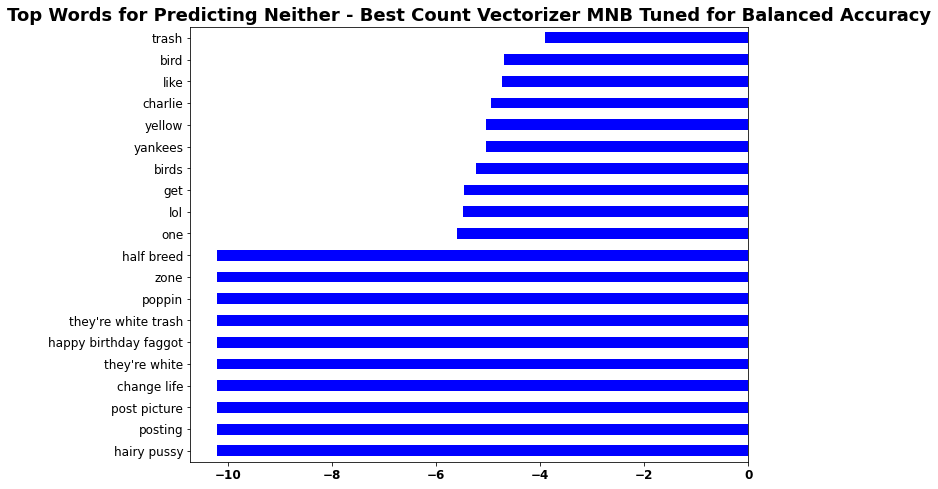

In [81]:
## Plot top 20 most important words for predicting each class and their weights
for i in range(0,3):
    plot_coefficients(mnb_cv_bacc_grid.best_estimator_, 'mnb', 'count_vec', i,
                      'Best Count Vectorizer MNB Tuned for Balanced Accuracy')

### Tuning TF-IDF MNB Models

------------------------------------------------------------
***** Grid Search Started at 10/30/20 - 18:55:24 PM
------------------------------------------------------------


***** Training Completed at 10/30/20 - 18:55:38 PM

***** Total Training Time: 0:00:13.705480


Best Parameters:
{'mnb__alpha': 1.0, 'tfidf_vec__min_df': 3, 'tfidf_vec__ngram_range': (1, 2)}


---------------------------------------------------------------------
Classification Report: Best TF-IDF Vectorizer MNB Tuned for Accuracy
---------------------------------------------------------------------
              precision    recall  f1-score   support

 Hate Speech       0.83      0.21      0.33       286
   Offensive       0.75      0.95      0.84       881
     Neither       0.90      0.89      0.89       833

    accuracy                           0.82      2000
   macro avg       0.83      0.68      0.69      2000
weighted avg       0.83      0.82      0.79      2000

-----------------------------------------

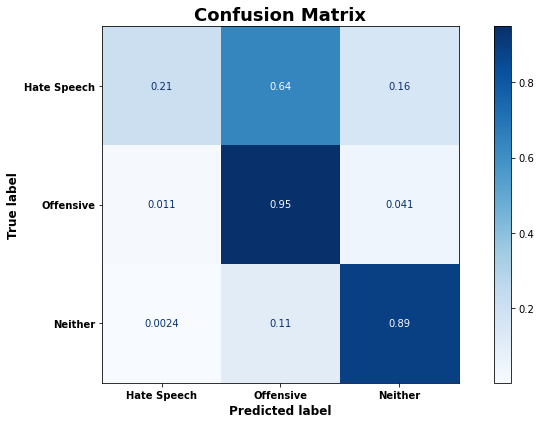

In [82]:
## define a grid of different hyperparameter values to be tested
params = {'tfidf_vec__ngram_range':[(1,1),(1,2),(1,3)],
          'tfidf_vec__min_df':[0.005, 2, 3],
          'mnb__alpha':[1.0, 1e-1, 1e-2]
         }

## run the grid search to test parameters and find the best estimator 
mnb_tfidf_acc_grid = fit_grid_clf(mnb_tfidf_pipe, params, 
                       X_train, y_train,
                       X_test, y_test,
                       model_descr='Best TF-IDF Vectorizer MNB Tuned for Accuracy',
                       score='accuracy')

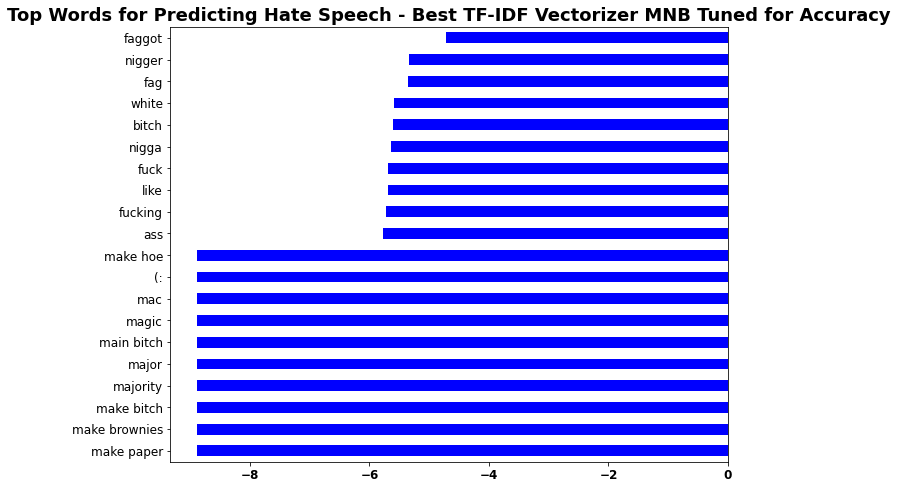

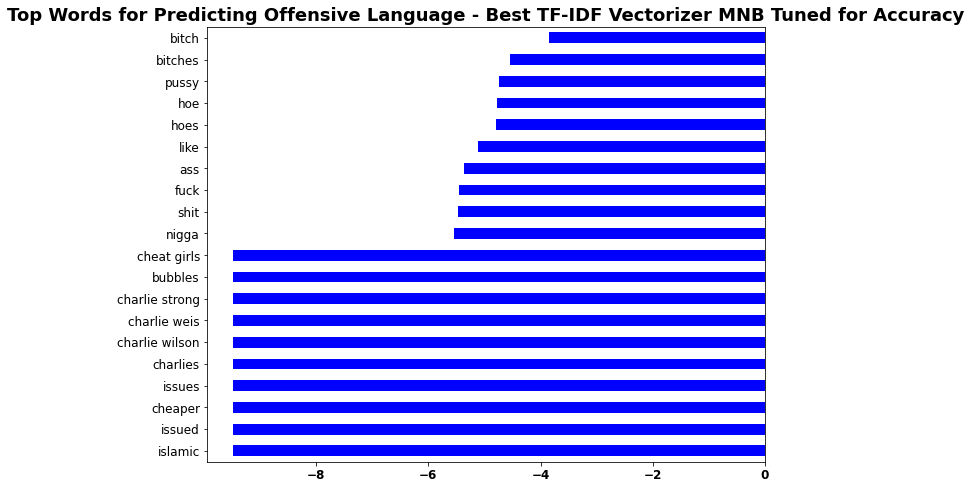

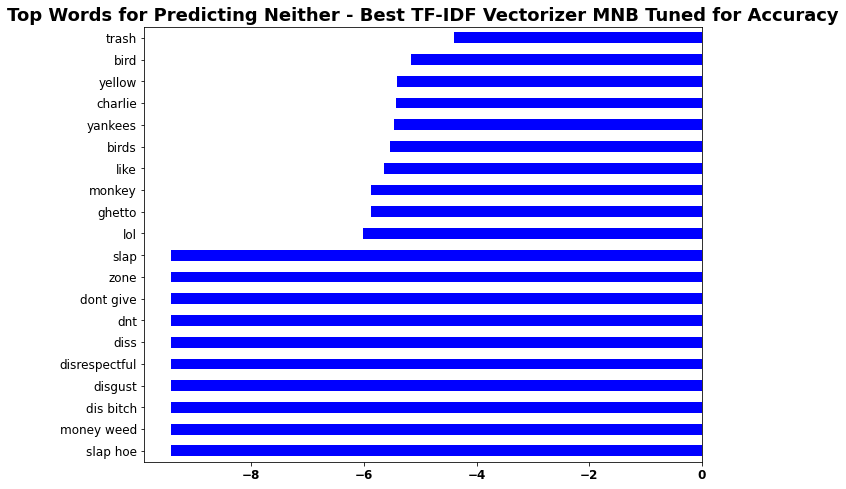

In [83]:
## Plot top 20 most important words for predicting each class and their weights
for i in range(0,3):
    plot_coefficients(mnb_tfidf_acc_grid.best_estimator_, 'mnb', 'tfidf_vec', i,
                      'Best TF-IDF Vectorizer MNB Tuned for Accuracy')

------------------------------------------------------------
***** Grid Search Started at 10/30/20 - 18:55:39 PM
------------------------------------------------------------


***** Training Completed at 10/30/20 - 18:55:52 PM

***** Total Training Time: 0:00:13.008490


Best Parameters:
{'mnb__alpha': 0.1, 'tfidf_vec__min_df': 3, 'tfidf_vec__ngram_range': (1, 2)}


------------------------------------------------------------------------------
Classification Report: Best TF-IDF Vectorizer MNB Tuned for Balanced Accuracy
------------------------------------------------------------------------------
              precision    recall  f1-score   support

 Hate Speech       0.62      0.35      0.45       286
   Offensive       0.77      0.90      0.83       881
     Neither       0.89      0.87      0.88       833

    accuracy                           0.81      2000
   macro avg       0.76      0.71      0.72      2000
weighted avg       0.80      0.81      0.80      2000

--------------

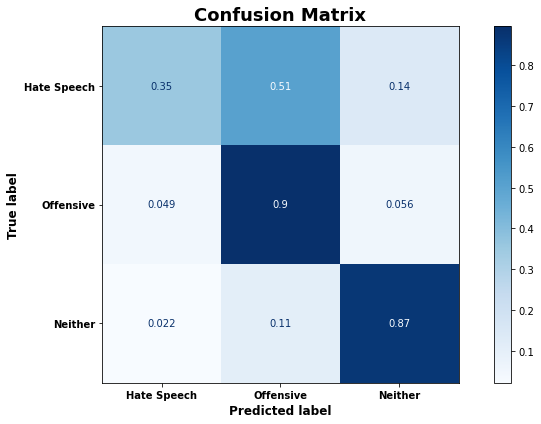

In [84]:
## define a grid of different hyperparameter values to be tested
params = {'tfidf_vec__ngram_range':[(1,1),(1,2),(1,3)],
          'tfidf_vec__min_df':[0.005, 2, 3],
          'mnb__alpha':[1.0, 1e-1, 1e-2]
         }

## run the grid search to test parameters and find the best estimator 
mnb_tfidf_bacc_grid = fit_grid_clf(mnb_tfidf_pipe, params, 
                       X_train, y_train,
                       X_test, y_test,
                       model_descr='Best TF-IDF Vectorizer MNB Tuned for Balanced Accuracy',
                       score='balanced_accuracy')

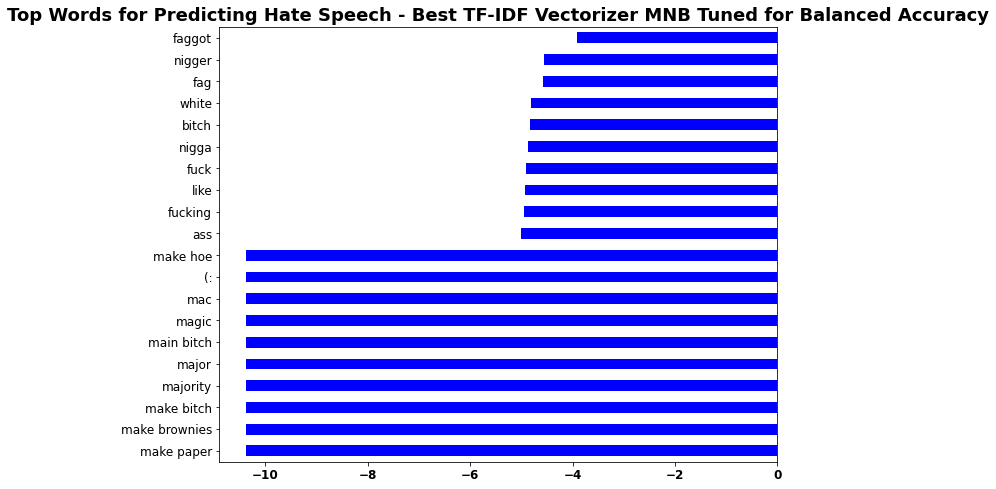

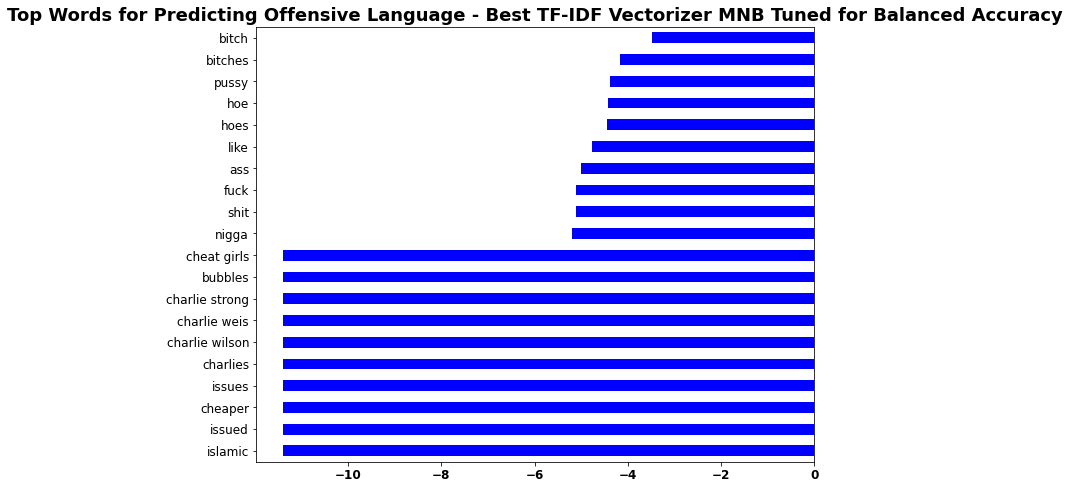

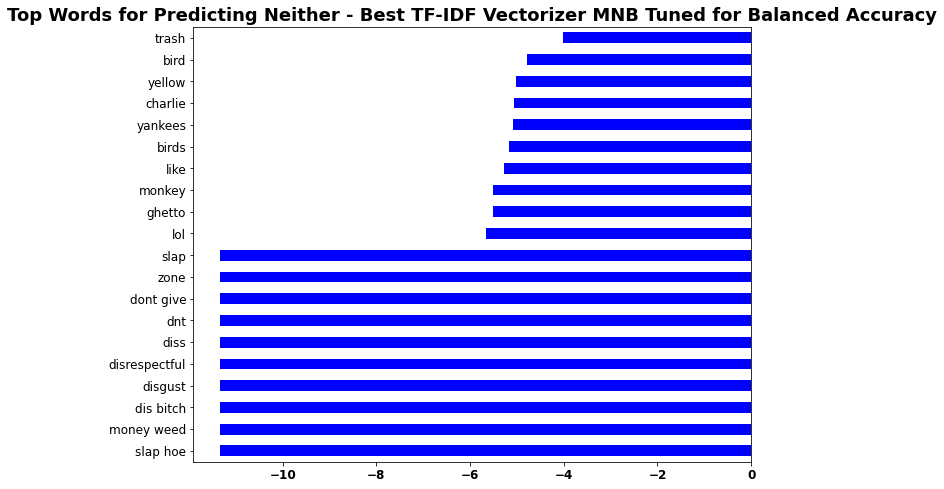

In [85]:
## Plot top 20 most important words for predicting each class and their weights
for i in range(0,3):
    plot_coefficients(mnb_tfidf_bacc_grid.best_estimator_, 'mnb', 'tfidf_vec', i,
                      'Best TF-IDF Vectorizer MNB Tuned for Balanced Accuracy')

## Hyperparameter Tuning for LinearSVC

### Tuning Count Vectorizer LinearSVC Models

------------------------------------------------------------
***** Grid Search Started at 10/30/20 - 18:55:54 PM
------------------------------------------------------------


***** Training Completed at 10/30/20 - 18:56:48 PM

***** Total Training Time: 0:00:54.700773


Best Parameters:
{'count_vec__min_df': 3, 'count_vec__ngram_range': (1, 3), 'svc__C': 0.1, 'svc__class_weight': None}


--------------------------------------------------------------------------
Classification Report: Best Count Vectorizer LinearSVC Tuned for Accuracy
--------------------------------------------------------------------------
              precision    recall  f1-score   support

 Hate Speech       0.71      0.53      0.60       286
   Offensive       0.87      0.89      0.88       881
     Neither       0.90      0.96      0.93       833

    accuracy                           0.86      2000
   macro avg       0.82      0.79      0.80      2000
weighted avg       0.86      0.86      0.86      2000

---

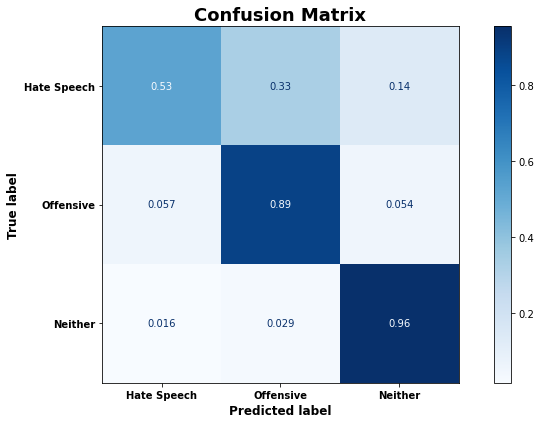

In [87]:
## define a grid of different hyperparameter values to be tested
params = {'count_vec__ngram_range':[(1,1),(1,2),(1,3)],
          'count_vec__min_df':[0.005, 2, 3],
          'svc__C':[1.0, 10, 100, 0.1, 0.001],
          'svc__class_weight':[None, 'balanced']
         }

## run the grid search to test parameters and find the best estimator 
svc_cv_acc_grid = fit_grid_clf(svc_cv_pipe, params, 
                       X_train, y_train,
                       X_test, y_test,
                       model_descr='Best Count Vectorizer LinearSVC Tuned for Accuracy',
                       score='accuracy')

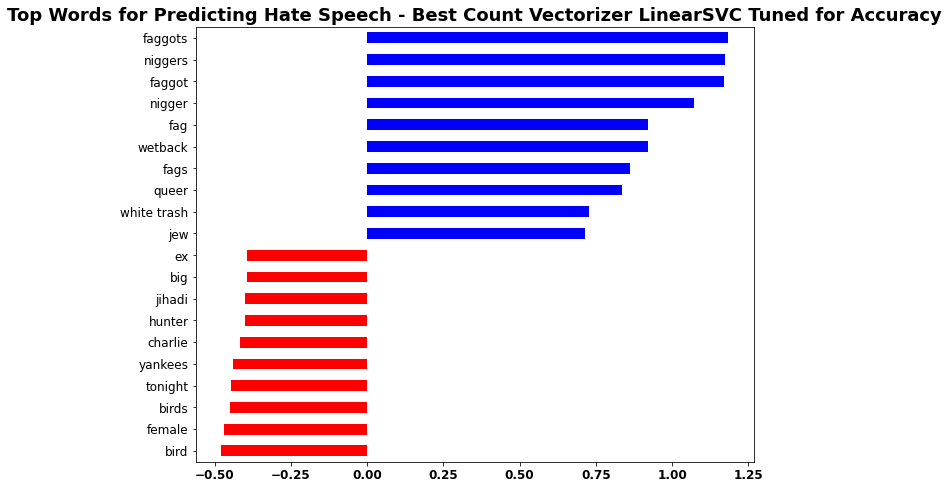

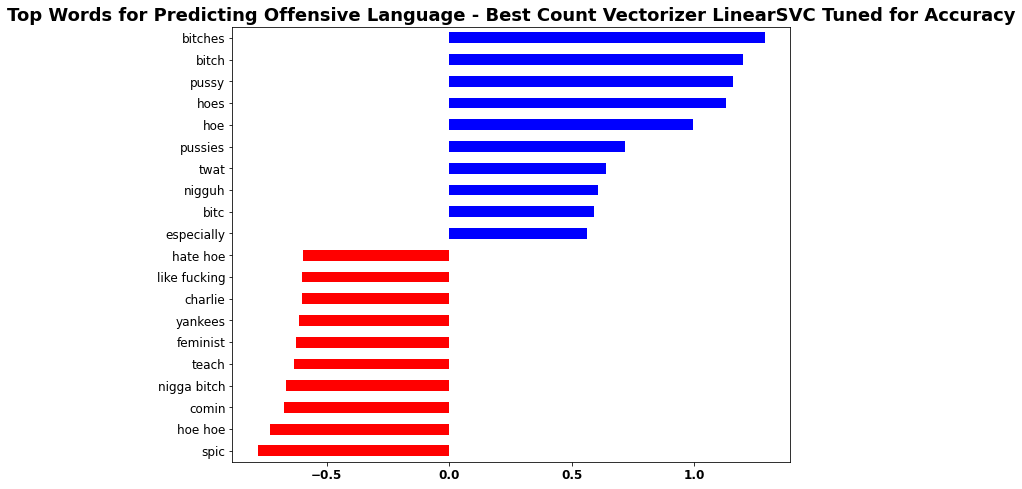

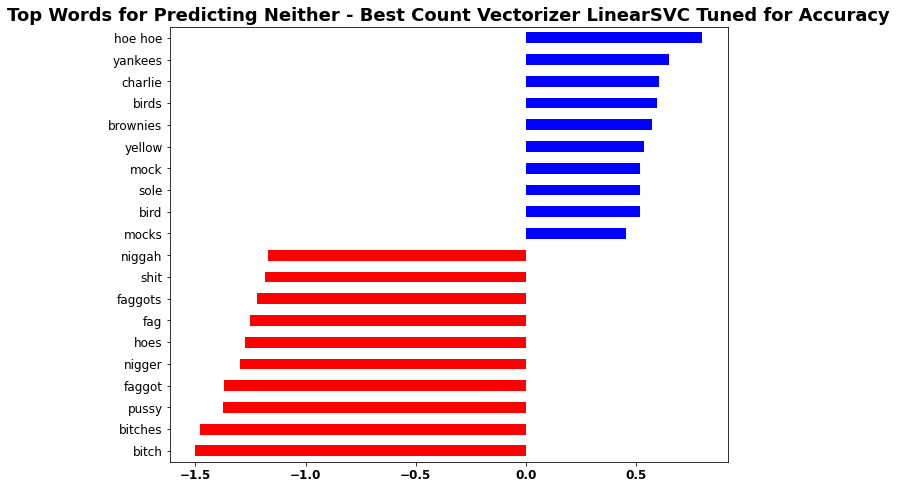

In [88]:
## Plot top 20 most important words for predicting each class and their weights
for i in range(0,3):
    plot_coefficients(svc_cv_acc_grid.best_estimator_, 'svc', 'count_vec', i,
                      'Best Count Vectorizer LinearSVC Tuned for Accuracy')

------------------------------------------------------------
***** Grid Search Started at 10/30/20 - 18:56:50 PM
------------------------------------------------------------


***** Training Completed at 10/30/20 - 18:57:47 PM

***** Total Training Time: 0:00:57.210762


Best Parameters:
{'count_vec__min_df': 2, 'count_vec__ngram_range': (1, 3), 'svc__C': 0.1, 'svc__class_weight': 'balanced'}


-----------------------------------------------------------------------------------
Classification Report: Best Count Vectorizer LinearSVC Tuned for Balanced Accuracy
-----------------------------------------------------------------------------------
              precision    recall  f1-score   support

 Hate Speech       0.66      0.63      0.64       286
   Offensive       0.88      0.86      0.87       881
     Neither       0.91      0.95      0.93       833

    accuracy                           0.86      2000
   macro avg       0.82      0.81      0.81      2000
weighted avg       0.86  

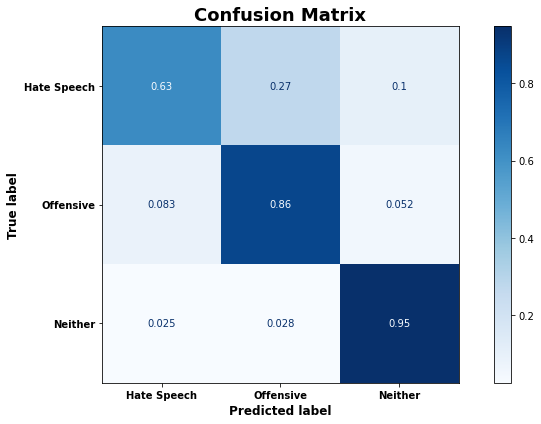

In [89]:
## define a grid of different hyperparameter values to be tested
params = {'count_vec__ngram_range':[(1,1),(1,2),(1,3)],
          'count_vec__min_df':[0.005, 2, 3],
          'svc__C':[1.0, 10, 100, 0.1, 0.001],
          'svc__class_weight':[None, 'balanced']
         }

## run the grid search to test parameters and find the best estimator 
svc_cv_bacc_grid = fit_grid_clf(svc_cv_pipe, params, 
                       X_train, y_train,
                       X_test, y_test,
                       model_descr='Best Count Vectorizer LinearSVC Tuned for Balanced Accuracy',
                       score='balanced_accuracy')

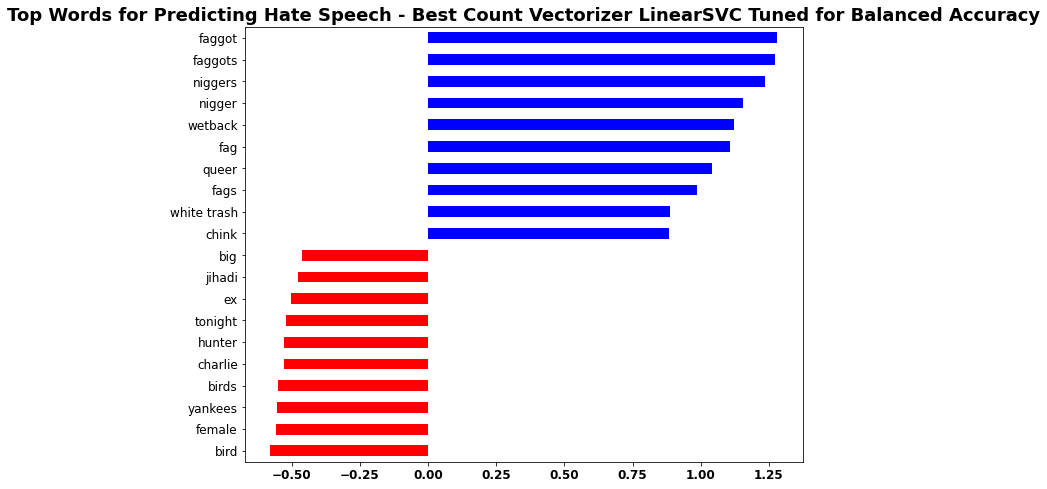

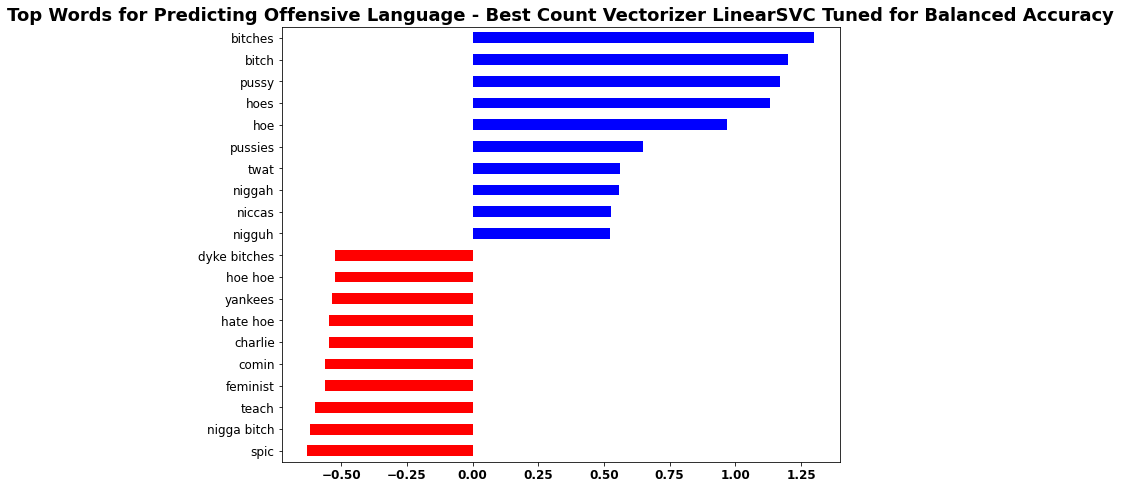

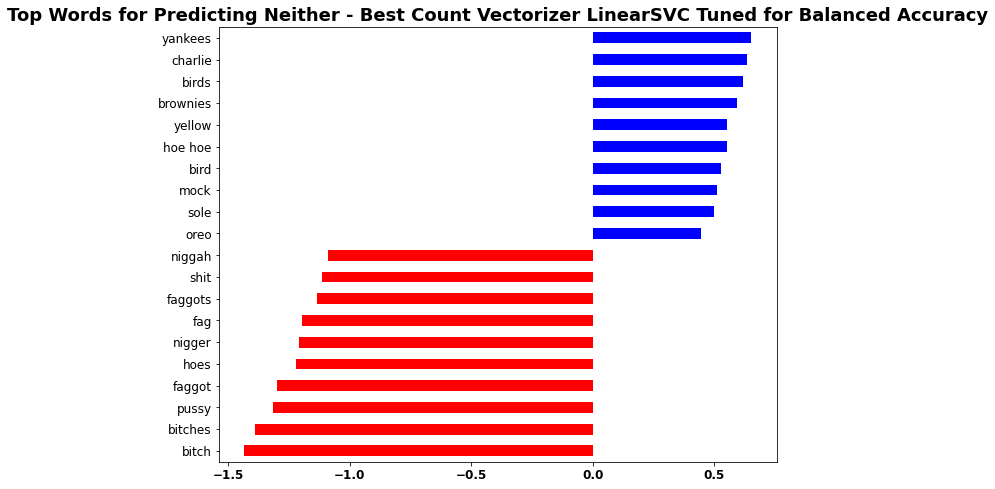

In [90]:
## Plot top 20 most important words for predicting each class and their weights
for i in range(0,3):
    plot_coefficients(svc_cv_bacc_grid.best_estimator_, 'svc', 'count_vec', i,
                      'Best Count Vectorizer LinearSVC Tuned for Balanced Accuracy')

### Tuning TF-IDF Vectorizer LinearSVC Models

------------------------------------------------------------
***** Grid Search Started at 10/30/20 - 18:57:48 PM
------------------------------------------------------------


***** Training Completed at 10/30/20 - 18:58:40 PM

***** Total Training Time: 0:00:51.936266


Best Parameters:
{'svc__C': 0.1, 'svc__class_weight': 'balanced', 'tfidf_vec__min_df': 2, 'tfidf_vec__ngram_range': (1, 3)}


---------------------------------------------------------------------------
Classification Report: Best TF-IDF Vectorizer LinearSVC Tuned for Accuracy
---------------------------------------------------------------------------
              precision    recall  f1-score   support

 Hate Speech       0.70      0.59      0.64       286
   Offensive       0.89      0.87      0.88       881
     Neither       0.89      0.96      0.92       833

    accuracy                           0.87      2000
   macro avg       0.83      0.81      0.81      2000
weighted avg       0.86      0.87      0.86      

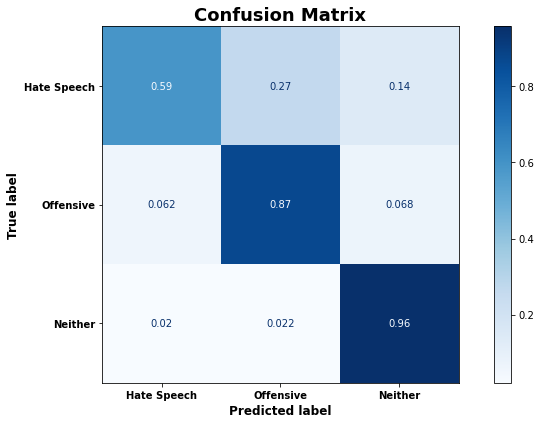

In [91]:
## define a grid of different hyperparameter values to be tested
params = {'tfidf_vec__ngram_range':[(1,1),(1,2),(1,3)],
          'tfidf_vec__min_df':[0.005, 2, 3],
          'svc__C':[1.0, 10, 100, 0.1, 0.001],
          'svc__class_weight':[None, 'balanced']
         }

## run the grid search to test parameters and find the best estimator 
svc_tfidf_acc_grid = fit_grid_clf(svc_tfidf_pipe, params, 
                       X_train, y_train,
                       X_test, y_test,
                       model_descr='Best TF-IDF Vectorizer LinearSVC Tuned for Accuracy',
                       score='accuracy')

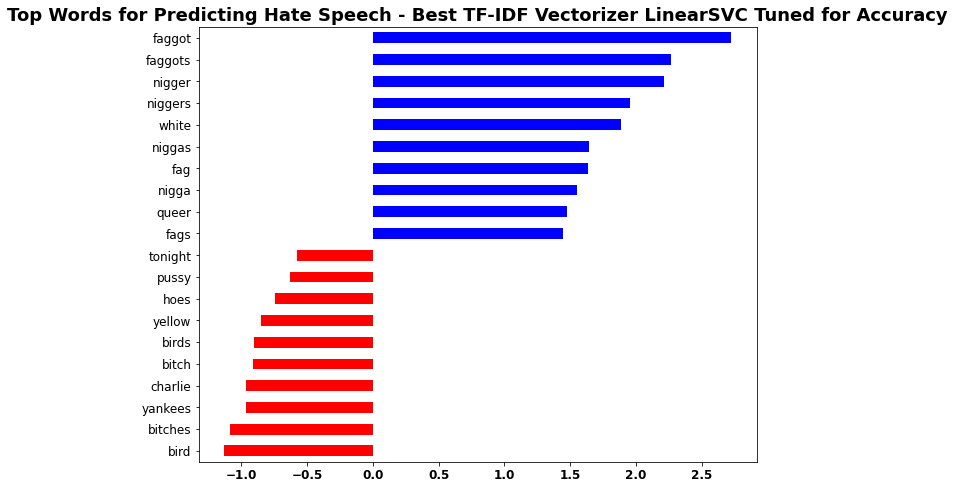

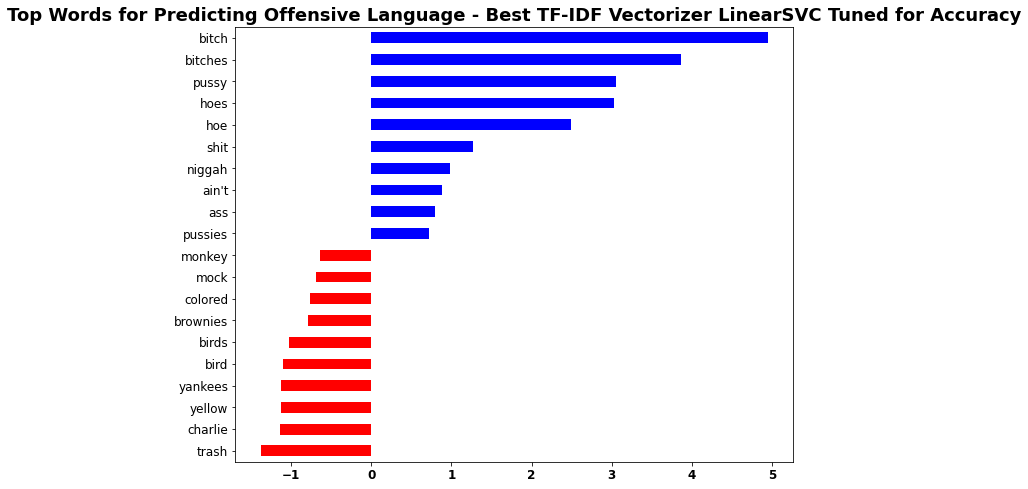

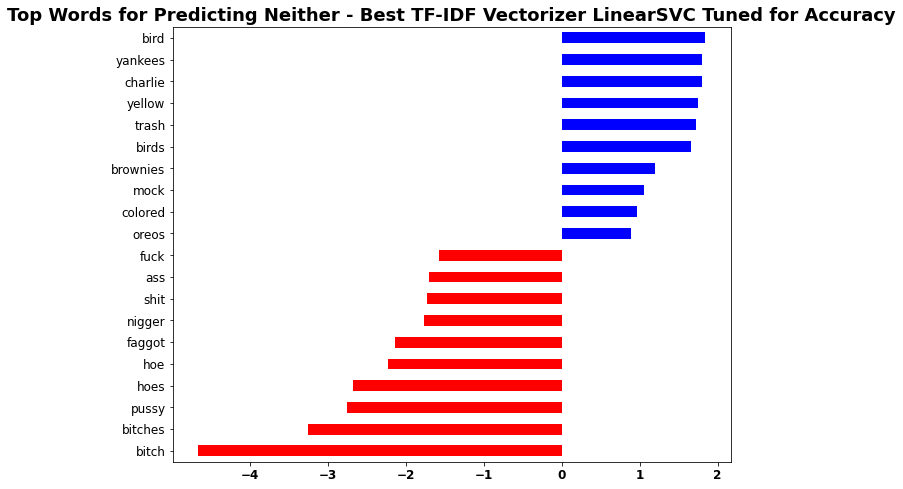

In [92]:
## Plot top 20 most important words for predicting each class and their weights
for i in range(0,3):
    plot_coefficients(svc_tfidf_acc_grid.best_estimator_, 'svc', 'tfidf_vec', i,
                      'Best TF-IDF Vectorizer LinearSVC Tuned for Accuracy')

------------------------------------------------------------
***** Grid Search Started at 10/30/20 - 18:58:41 PM
------------------------------------------------------------


***** Training Completed at 10/30/20 - 18:59:33 PM

***** Total Training Time: 0:00:51.189314


Best Parameters:
{'svc__C': 0.1, 'svc__class_weight': 'balanced', 'tfidf_vec__min_df': 3, 'tfidf_vec__ngram_range': (1, 3)}


------------------------------------------------------------------------------------
Classification Report: Best TF-IDF Vectorizer LinearSVC Tuned for Balanced Accuracy
------------------------------------------------------------------------------------
              precision    recall  f1-score   support

 Hate Speech       0.68      0.59      0.63       286
   Offensive       0.89      0.86      0.88       881
     Neither       0.89      0.96      0.92       833

    accuracy                           0.86      2000
   macro avg       0.82      0.80      0.81      2000
weighted avg       0.8

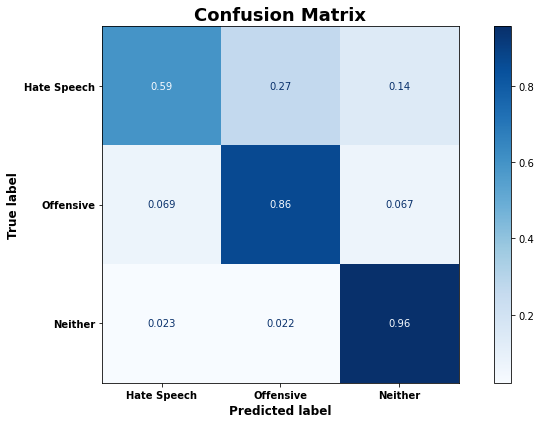

In [93]:
## define a grid of different hyperparameter values to be tested
params = {'tfidf_vec__ngram_range':[(1,1),(1,2),(1,3)],
          'tfidf_vec__min_df':[0.005, 2, 3],
          'svc__C':[1.0, 10, 100, 0.1, 0.001],
          'svc__class_weight':[None, 'balanced']
         }

## run the grid search to test parameters and find the best estimator 
svc_tfidf_bacc_grid = fit_grid_clf(svc_tfidf_pipe, params, 
                       X_train, y_train,
                       X_test, y_test,
                       model_descr='Best TF-IDF Vectorizer LinearSVC Tuned for Balanced Accuracy',
                       score='balanced_accuracy')

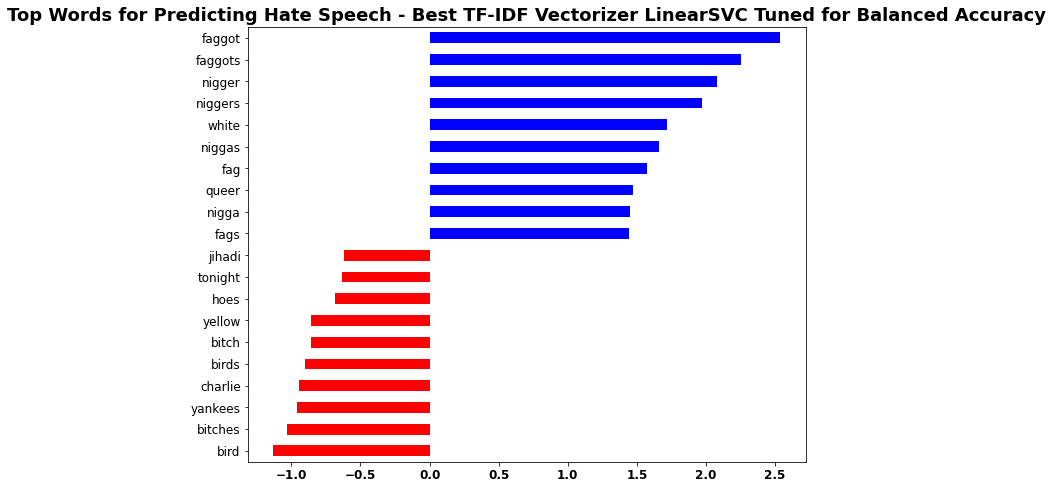

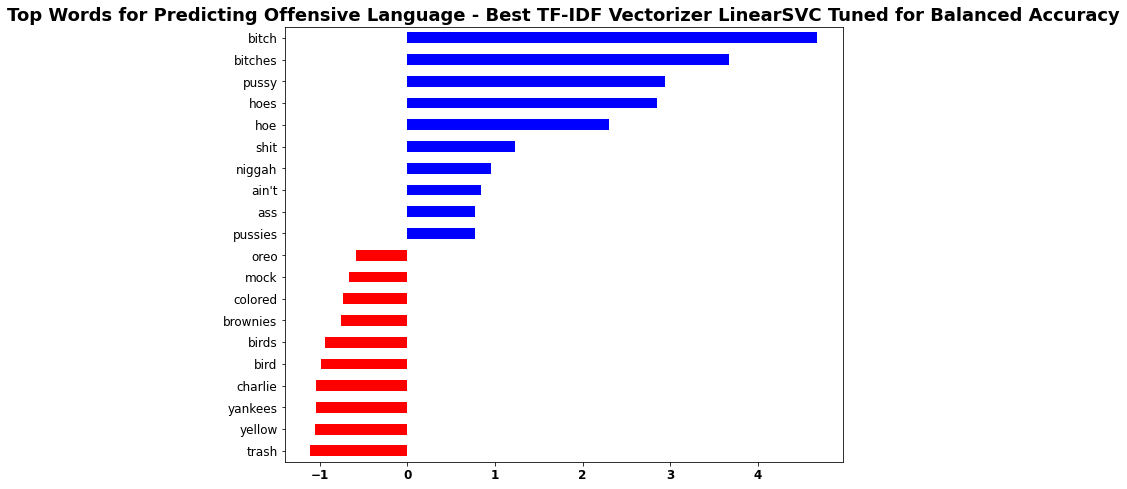

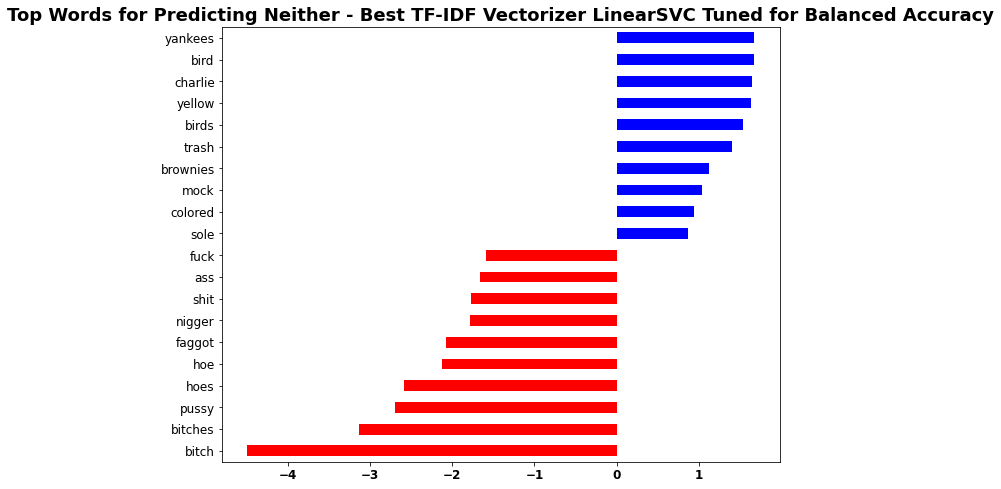

In [94]:
## Plot top 20 most important words for predicting each class and their weights
for i in range(0,3):
    plot_coefficients(svc_tfidf_bacc_grid.best_estimator_, 'svc', 'tfidf_vec', i,
                      'Best TF-IDF Vectorizer LinearSVC Tuned for Balanced Accuracy')

## Hyperparameter Tuning for XGB Classifiers

### Tuning Count Vectorizer XGB Models

------------------------------------------------------------
***** Grid Search Started at 10/30/20 - 18:59:34 PM
------------------------------------------------------------


***** Training Completed at 10/30/20 - 19:08:27 PM

***** Total Training Time: 0:08:53.337340


Best Parameters:
{'count_vec__min_df': 2, 'count_vec__ngram_range': (1, 2), 'xgb__colsample_bytree': 0.7, 'xgb__max_depth': 6, 'xgb__subsample': 0.7}


--------------------------------------------------------------------
Classification Report: Best Count Vectorizer XGB Tuned for Accuracy
--------------------------------------------------------------------
              precision    recall  f1-score   support

 Hate Speech       0.74      0.40      0.52       286
   Offensive       0.87      0.88      0.87       881
     Neither       0.84      0.97      0.90       833

    accuracy                           0.85      2000
   macro avg       0.82      0.75      0.76      2000
weighted avg       0.84      0.85      0.83 

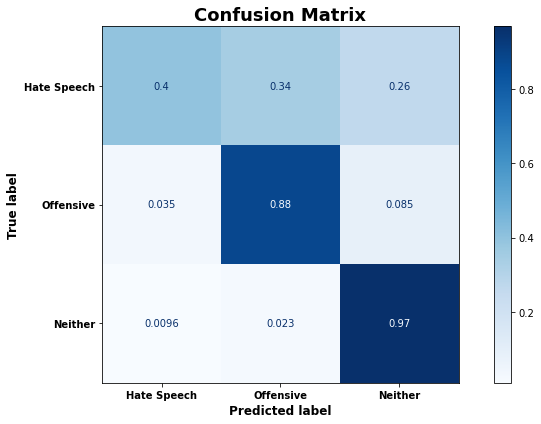

In [96]:
## define a grid of different hyperparameter values to be tested
params = {'count_vec__ngram_range':[(1,1),(1,2)],
          'count_vec__min_df':[0.005, 2],
          'xgb__max_depth':[3, 6],
          'xgb__subsample': [0.7, 1],
          'xgb__colsample_bytree':[0.7, 1]
         }

## run the grid search to test parameters and find the best estimator 
xgb_cv_acc_grid = fit_grid_clf(xgb_cv_pipe, params, 
                       X_train, y_train,
                       X_test, y_test,
                       model_descr='Best Count Vectorizer XGB Tuned for Accuracy',
                       score='accuracy')

------------------------------------------------------------
***** Grid Search Started at 10/30/20 - 19:08:28 PM
------------------------------------------------------------


***** Training Completed at 10/30/20 - 19:16:45 PM

***** Total Training Time: 0:08:17.022825


Best Parameters:
{'count_vec__min_df': 2, 'count_vec__ngram_range': (1, 1), 'xgb__colsample_bytree': 0.7, 'xgb__max_depth': 6, 'xgb__subsample': 0.7}


-----------------------------------------------------------------------------
Classification Report: Best Count Vectorizer XGB Tuned for Balanced Accuracy
-----------------------------------------------------------------------------
              precision    recall  f1-score   support

 Hate Speech       0.72      0.42      0.53       286
   Offensive       0.86      0.87      0.87       881
     Neither       0.85      0.96      0.90       833

    accuracy                           0.84      2000
   macro avg       0.81      0.75      0.77      2000
weighted avg     

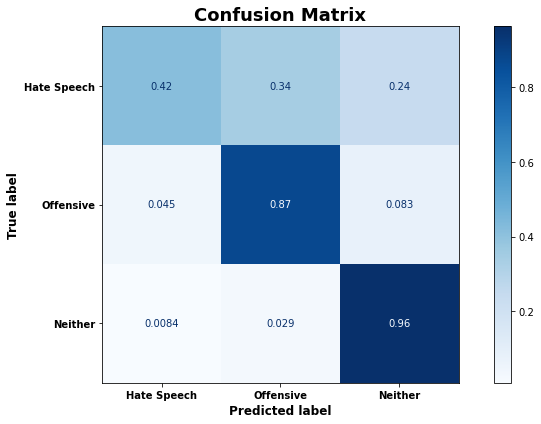

In [97]:
## define a grid of different hyperparameter values to be tested
params = {'count_vec__ngram_range':[(1,1),(1,2)],
          'count_vec__min_df':[0.005, 2],
          'xgb__max_depth':[3, 6],
          'xgb__subsample': [0.7, 1],
          'xgb__colsample_bytree':[0.7, 1]
         }

## run the grid search to test parameters and find the best estimator 
xgb_cv_bacc_grid = fit_grid_clf(xgb_cv_pipe, params, 
                       X_train, y_train,
                       X_test, y_test,
                       model_descr='Best Count Vectorizer XGB Tuned for Balanced Accuracy',
                       score='balanced_accuracy')

### Tuning TF-IDF Vectorizer XGB Models

------------------------------------------------------------
***** Grid Search Started at 10/30/20 - 19:16:46 PM
------------------------------------------------------------


***** Training Completed at 10/30/20 - 19:25:02 PM

***** Total Training Time: 0:08:16.115041


Best Parameters:
{'tfidf_vec__min_df': 2, 'tfidf_vec__ngram_range': (1, 2), 'xgb__colsample_bytree': 1, 'xgb__max_depth': 6, 'xgb__subsample': 0.7}


---------------------------------------------------------------------
Classification Report: Best TF-IDF Vectorizer XGB Tuned for Accuracy
---------------------------------------------------------------------
              precision    recall  f1-score   support

 Hate Speech       0.68      0.46      0.55       286
   Offensive       0.86      0.88      0.87       881
     Neither       0.87      0.95      0.91       833

    accuracy                           0.85      2000
   macro avg       0.81      0.76      0.78      2000
weighted avg       0.84      0.85      0.84

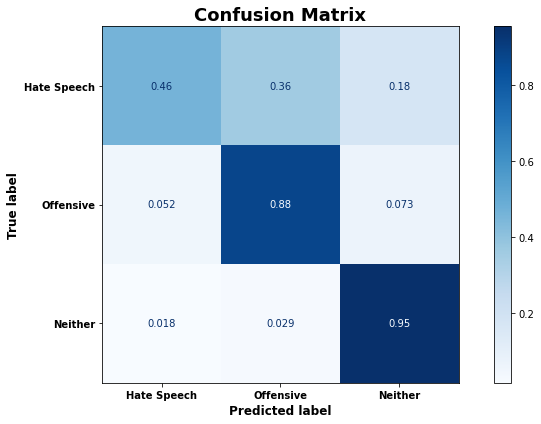

In [98]:
## define a grid of different hyperparameter values to be tested
params = {'tfidf_vec__ngram_range':[(1,1),(1,2)],
          'tfidf_vec__min_df':[0.005, 2],
          'xgb__max_depth':[3, 6],
          'xgb__subsample': [0.7, 1],
          'xgb__colsample_bytree':[0.7, 1]
         }

## run the grid search to test parameters and find the best estimator 
xgb_tfidf_acc_grid = fit_grid_clf(xgb_tfidf_pipe, params, 
                       X_train, y_train,
                       X_test, y_test,
                       model_descr='Best TF-IDF Vectorizer XGB Tuned for Accuracy',
                       score='accuracy')

------------------------------------------------------------
***** Grid Search Started at 10/30/20 - 19:25:02 PM
------------------------------------------------------------


***** Training Completed at 10/30/20 - 19:33:20 PM

***** Total Training Time: 0:08:17.248129


Best Parameters:
{'tfidf_vec__min_df': 2, 'tfidf_vec__ngram_range': (1, 2), 'xgb__colsample_bytree': 1, 'xgb__max_depth': 6, 'xgb__subsample': 0.7}


------------------------------------------------------------------------------
Classification Report: Best TF-IDF Vectorizer XGB Tuned for Balanced Accuracy
------------------------------------------------------------------------------
              precision    recall  f1-score   support

 Hate Speech       0.68      0.46      0.55       286
   Offensive       0.86      0.88      0.87       881
     Neither       0.87      0.95      0.91       833

    accuracy                           0.85      2000
   macro avg       0.81      0.76      0.78      2000
weighted avg    

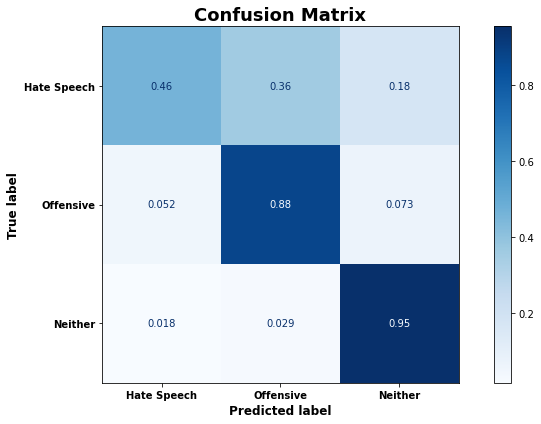

In [99]:
## define a grid of different hyperparameter values to be tested
params = {'tfidf_vec__ngram_range':[(1,1),(1,2)],
          'tfidf_vec__min_df':[0.005, 2],
          'xgb__max_depth':[3, 6],
          'xgb__subsample': [0.7, 1],
          'xgb__colsample_bytree':[0.7, 1]
         }

## run the grid search to test parameters and find the best estimator 
xgb_tfidf_bacc_grid = fit_grid_clf(xgb_tfidf_pipe, params, 
                       X_train, y_train,
                       X_test, y_test,
                       model_descr='Best TF-IDF Vectorizer XGB Tuned for Balanced Accuracy',
                       score='balanced_accuracy')

# INTERPRET

## Final Model - Best LinearSVC

The all around best model was the LinearSVC model using the Count Vectorizer and tuned to optimize balanced accuracy. This model had one of the highest overall accuracies (84%) and by far the highest recall for correctly classifying hate speech as hate speech 63% of the time. The model retained one of the highest recalls for predicting the neither class correctly for 95% of test cases and did not sacrifice much in recall for offensive tweets, labeling that class correctly 86% of the time.

---------------------------------------------------------------------------------------
Classification Report: Best Model - Count Vector LinearSVC Tuned for Balanced Accuracy
---------------------------------------------------------------------------------------
              precision    recall  f1-score   support

 Hate Speech       0.66      0.63      0.64       286
   Offensive       0.88      0.86      0.87       881
     Neither       0.91      0.95      0.93       833

    accuracy                           0.86      2000
   macro avg       0.82      0.81      0.81      2000
weighted avg       0.86      0.86      0.86      2000

---------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------




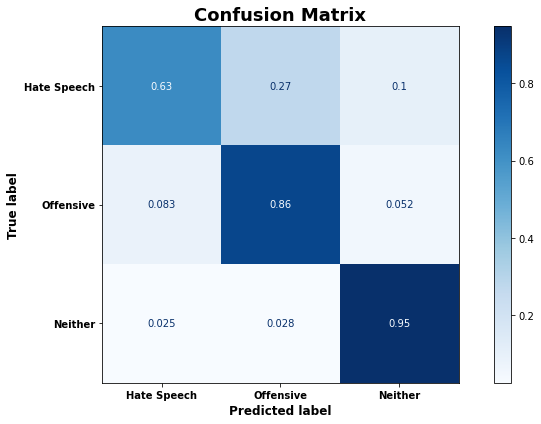

In [100]:
## Print classification report and confusion matrix for best model
eval_classifier(svc_cv_bacc_grid.best_estimator_, X_test, y_test,
                model_descr='Best Model - Count Vector LinearSVC Tuned for Balanced Accuracy');

> - As shown below, the best model relied heavily on various queer and racial slurs to push it towards a classification of hate speech. The singular and plural version of many of these words show up in the top 10 positive predictors of the hate speech class. Thus, in the next subsection I trained the same model on a lemmatized version of the same training data to see if this improved model performance (it did, but barely) and to examine what additional words appear as top predictors when singular and plural versions of slurs are treated as the same word.
- Words that were most negatively associated with hate speech (in that their presence in a tweet pushed the model towards either offensive language or neither) mostly seem fairly random and benign ("big", "tonight", "hunter", and "charlie". "Female" may show up because if someone is using that word then they are probably using it rather than words like "bitch(es)" and "ho/e(s)" which were major positive predictors of offensive language tweets. However "bird(s)", while obviously commonly referring to a type of animal can also be used as a slang term usually to refer to white people. From <a href="https://www.urbandictionary.com/define.php?term=bird">Urban Dictionary</a>, the term bird can refer to "a mentality developed by basic women often aged 18-25, often white (although can be any ethnic background)" or "generally a girl or young woman who comes across as vain, ditzy, stupid or useless." 

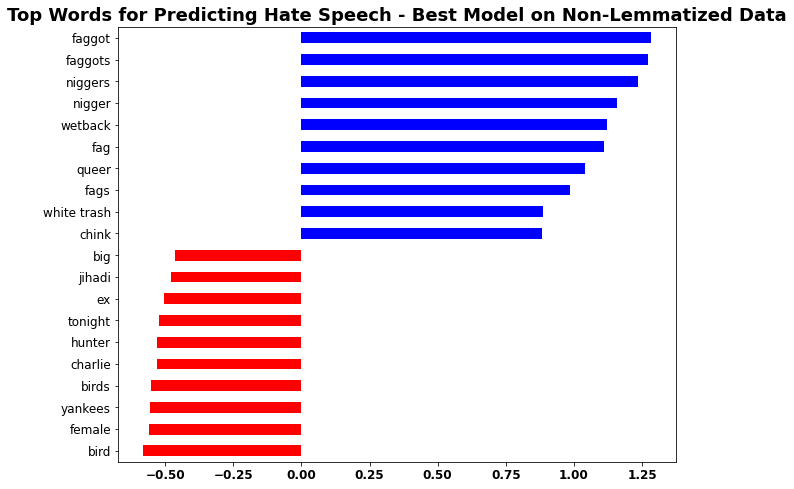

In [101]:
## Plot top 20 most important words for predicting hate speech and their weights
plot_coefficients(svc_cv_bacc_grid.best_estimator_, 'svc', 'count_vec', 0,
                      'Best Model on Non-Lemmatized Data');

> - Shown below, words that most strongly push the model towards a classification of "offensive language" fall into two general categories: terms that are offensive and derogative of women and femininity ("bitch(es)", ("hoe(s)", "pussy/ies", and "twat") and modified versions of the n-word ("niggah", "niccas", "nigguh"). These words are less common in hate speech, but are definitely deemed offensive by most people. 
- As seen for predicting hate speech, the model relies most heavily on positive predictors rather than negative predictors. Some top negative predictors of offensive language are terms that would be more indicative of hate speech (but that interestingly did not make the top list for hate speech) such as "spic" and "dyke bitches". 

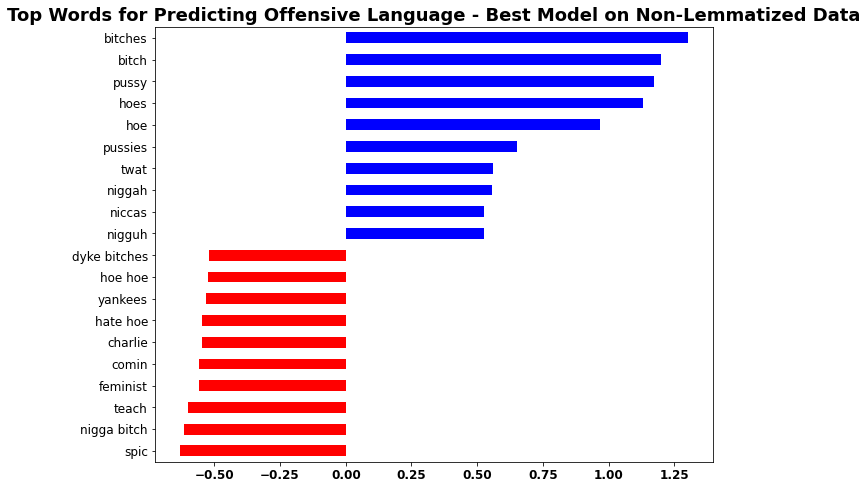

In [102]:
## Plot top 20 most important words for predicting offensive language and their weights
plot_coefficients(svc_cv_bacc_grid.best_estimator_, 'svc', 'count_vec', 1,
                      'Best Model on Non-Lemmatized Data');

>- As shown below, predictions of the "neither" class are most influenced by negative coefficients rather than positive coefficients. Basically the inclusion of the terms represented by red bars strongly push the model to predict a different class (either hate speech or offensive language). The inclusion of any particular word does not strongly indicate that the tweet belongs to the neither class, so essentially the model is ruling out those two classes before predicting neither. This would explain why the top positive coefficients are fairly small and the words themselves seem relatively random. The top positive predictors of the neither class would likely vary quite a bit depending on the sample of training data. However, the top negative predictors of the neither class are unlikely to vary much as those are generally extremely indicative of hate speech and/or offensive language. In fact, the list of top negative predictors consists entirely of curse words and slurs.

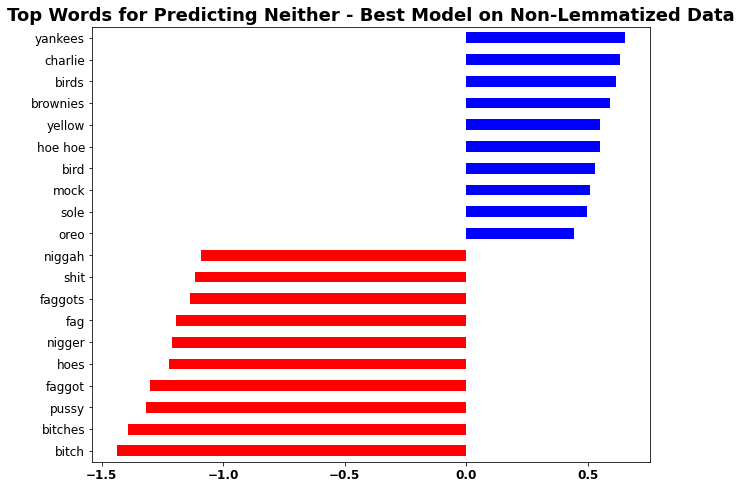

In [103]:
## Plot top 20 most important words for predicting neither and their weights
plot_coefficients(svc_cv_bacc_grid.best_estimator_, 'svc', 'count_vec', 2,
                      'Best Model on Non-Lemmatized Data');

## Final Model Trained on Lemmatized Data

>- Since many of the top predictors of hate speech and offensive language were the singular and plural versions of slurs, lemmatizing the data to convert plurals into singulars may improve model performance. Below I fit and evaluate a model on the same train-test split used for all other models, but with a lemmatized version of the text. The lemmatized version of the best model performs marginally better with the same overall accuracy of the original model (86%) and 65% recall of hate speech (a slight improvement over the original 63%) with a slight decrease in recall for the neither class (from 95% to 94%). Since this model performs slightly better for the class of interest without unnecessarily flagging many more inoffensive ("neither") tweets as hate speech, I consider this the best modeling approach and will focus the rest of the interpretation and the recommendations on this model.

In [104]:
## Display parameters for best model
svc_cv_bacc_grid.best_params_

{'count_vec__min_df': 2,
 'count_vec__ngram_range': (1, 3),
 'svc__C': 0.1,
 'svc__class_weight': 'balanced'}

------------------------------------------------------------
***** Grid Search Started at 10/30/20 - 19:33:22 PM
------------------------------------------------------------


***** Training Completed at 10/30/20 - 19:33:23 PM

***** Total Training Time: 0:00:01.048788


Best Parameters:
{'count_vec__min_df': 2, 'count_vec__ngram_range': (1, 3), 'svc__C': 0.1, 'svc__class_weight': 'balanced'}


-------------------------------------------------------
Classification Report: Best Model on Lemmatized Data
-------------------------------------------------------
              precision    recall  f1-score   support

 Hate Speech       0.65      0.65      0.65       286
   Offensive       0.89      0.86      0.87       881
     Neither       0.91      0.94      0.92       833

    accuracy                           0.86      2000
   macro avg       0.82      0.82      0.82      2000
weighted avg       0.86      0.86      0.86      2000

-------------------------------------------------------


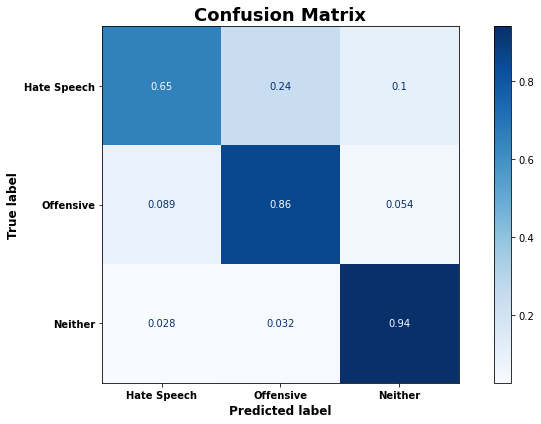

In [105]:
## Train a model on the lemmatized data using the parameters of the best model
params = {'count_vec__min_df': [2],
          'count_vec__ngram_range': [(1, 3)],
          'svc__C': [0.1],
          'svc__class_weight': ['balanced']}

lemma_svc_cv_bacc_grid = fit_grid_clf(svc_cv_pipe, params, 
                       X_lemma_train, y_lemma_train,
                       X_lemma_test, y_lemma_test,
                       model_descr='Best Model on Lemmatized Data',
                       score='balanced_accuracy')

> - As shown below and previously seen for the same model trained on non-lemmatized data, this model relies heavily on various queer and racial slurs to push it towards a classification of hate speech. The original singular predictors show up in addition to "jew", "feminist", and "dyke".  
- Words that were most negatively associated with hate speech (in that their presence in a tweet pushed the model towards either offensive language or neither) stayed mostly the same. 

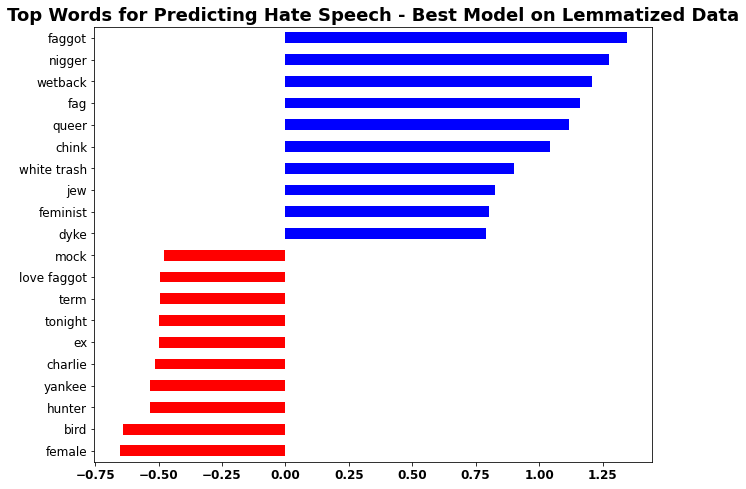

In [106]:
## Plot top 20 most important words for predicting hate speech and their weights
plot_coefficients(lemma_svc_cv_bacc_grid.best_estimator_, 'svc', 'count_vec', 0,
                      'Best Model on Lemmatized Data');

> - As before, words that most strongly push the model towards a classification of "offensive language" fall into two general categories: terms that are offensive and derogative of women and femininity and modified versions of the n-word. These words are less common in hate speech, but are definitely deemed offensive by most people. The words are the main predictors of offensive language and the model trained on lemmatized data is starting to give weight to words like "especially" which are not inherently offensive.

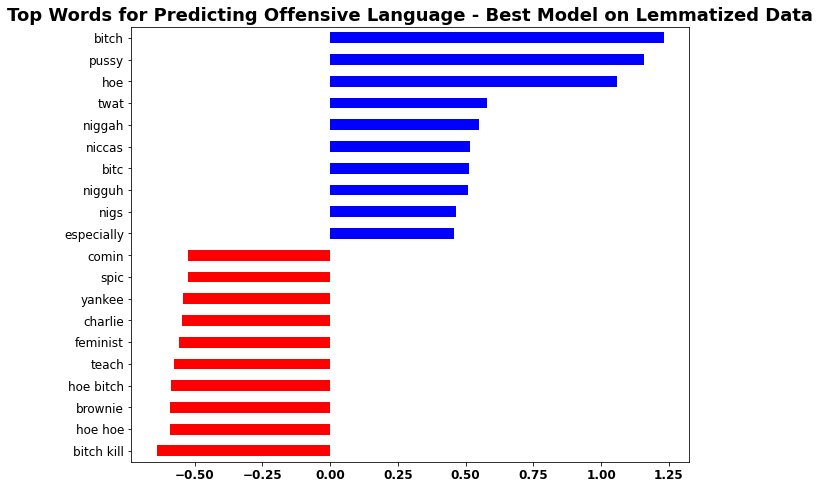

In [107]:
## Plot top 20 most important words for predicting offensive language and their weights
plot_coefficients(lemma_svc_cv_bacc_grid.best_estimator_, 'svc', 'count_vec', 1,
                      'Best Model on Lemmatized Data');

>- As seen before, predictions of the "neither" class are most influenced by negative coefficients rather than positive coefficients. The inclusion of any particular word does not strongly indicate that the tweet belongs to the neither class, so essentially the model is ruling out those two classes before predicting neither. This would explain why the top positive coefficients are fairly small and the words themselves seem relatively random. Once again, the top negative predictors of the neither class are curse words and slurs.

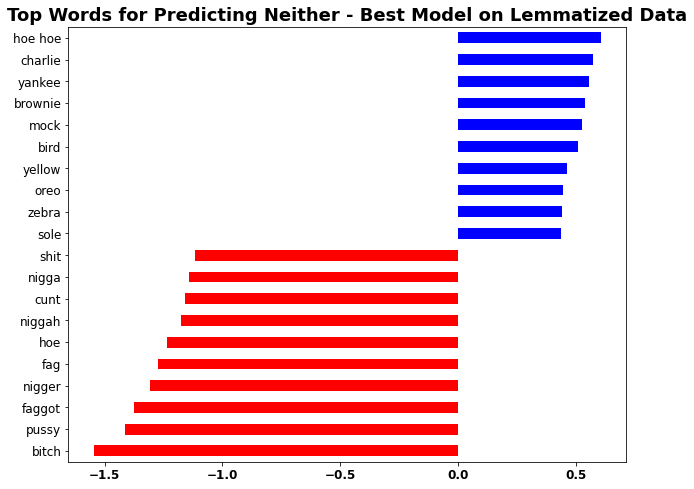

In [108]:
## Plot top 20 most important words for predicting neither and their weights
plot_coefficients(lemma_svc_cv_bacc_grid.best_estimator_, 'svc', 'count_vec', 2,
                      'Best Model on Lemmatized Data');

### Analyzing Misclassifications

In [110]:
## Store best model's predictions for test data
svm_predictions = lemma_svc_cv_bacc_grid.best_estimator_.predict(X_lemma_test)

In [111]:
## Create DataFrame of incorrect predictions
row_index_list = []
incorrect_pred_list = []
true_label_list = []
tweet_list = []
stop_tokens_list = []
lemma_tokens_list = []
hate_count = []
off_count = []
neither_count = []
total_count = []

class_dict = {0: 'hate speech', 1: 'offensive', 2: 'neither'}
for row_index, (input, X_lemma_idx,
                prediction, label) in enumerate(zip (X_lemma_test, list(X_lemma_test.index),
                                                     svm_predictions, y_lemma_test)):
    if prediction != label:
        # col for row index (which prediction of X_lemma_test's 2000 samples)
        row_index_list.append(row_index)
        # col for model's prediction (as class name, not code)
        incorrect_pred_list.append(class_dict[prediction])
        # col for true label (as class name, not code) 
        true_label_list.append(class_dict[label])
        # col for hate speech vote count 
        hate_count.append(df.iloc[X_lemma_idx]['hate_speech'])
        # col for offensive lang vote count 
        off_count.append(df.iloc[X_lemma_idx]['offensive_language'])
        # col for neither vote count 
        neither_count.append(df.iloc[X_lemma_idx]['neither'])
        # col for total vote count 
        total_count.append(df.iloc[X_lemma_idx]['count'])
        # col for tweet text
        tweet_list.append(df.iloc[X_lemma_idx]['tweet'])
        # col for stopped tokens
        stop_tokens_list.append(df.iloc[X_lemma_idx]['tokens_stopped'])
        # col for lemmatized tokens
        lemma_tokens_list.append(df.iloc[X_lemma_idx]['lemma_tokens'])

        
incorrect_preds = zip(row_index_list, incorrect_pred_list,
                      true_label_list, hate_count, off_count,
                      neither_count, total_count, tweet_list,
                      stop_tokens_list, lemma_tokens_list)

incorrect_preds_df = pd.DataFrame(incorrect_preds, 
                                  columns=['row index', 'prediction',
                                           'true label', 'hate votes',
                                           'off votes', 'neither votes',
                                           'total votes', 'text', 
                                           'stopped tokens', 'lemma tokens'])

# Create new cols in df based on proportion of votes per category
incorrect_preds_df['proportion hate'] = incorrect_preds_df['hate votes'] / incorrect_preds_df['total votes']
incorrect_preds_df['proportion off'] = incorrect_preds_df['off votes'] / incorrect_preds_df['total votes']
incorrect_preds_df['proportion neither'] = incorrect_preds_df['neither votes'] / incorrect_preds_df['total votes']

# Create column noting predict is incorrect for concatenating prediction dfs
incorrect_preds_df['correct'] = 0

# incorrect_preds_df



## Create DataFrame of correct predictions
row_index_list = []
pred_list = []
true_label_list = []
tweet_list = []
stop_tokens_list = []
lemma_tokens_list = []
hate_count = []
off_count = []
neither_count = []
total_count = []

class_dict = {0: 'hate speech', 1: 'offensive', 2: 'neither'}
for row_index, (input, X_lemma_idx,
                prediction, label) in enumerate(zip (X_lemma_test, list(X_lemma_test.index),
                                                     svm_predictions, y_lemma_test)):
    if prediction == label:
        # col for row index (which prediction of X_lemma_test's 2000 samples)
        row_index_list.append(row_index)
        # col for model's prediction (as class name, not code)
        pred_list.append(class_dict[prediction])
        # col for true label (as class name, not code) 
        true_label_list.append(class_dict[label])
        # col for hate speech vote count 
        hate_count.append(df.iloc[X_lemma_idx]['hate_speech'])
        # col for offensive lang vote count 
        off_count.append(df.iloc[X_lemma_idx]['offensive_language'])
        # col for neither vote count 
        neither_count.append(df.iloc[X_lemma_idx]['neither'])
        # col for total vote count 
        total_count.append(df.iloc[X_lemma_idx]['count'])
        # col for tweet text
        tweet_list.append(df.iloc[X_lemma_idx]['tweet'])
        # col for stopped tokens
        stop_tokens_list.append(df.iloc[X_lemma_idx]['tokens_stopped'])
        # col for lemmatized tokens
        lemma_tokens_list.append(df.iloc[X_lemma_idx]['lemma_tokens'])

        
correct_preds = zip(row_index_list, pred_list,
                      true_label_list, hate_count, off_count,
                      neither_count, total_count, tweet_list,
                      stop_tokens_list, lemma_tokens_list)

correct_preds_df = pd.DataFrame(correct_preds, 
                                  columns=['row index', 'prediction',
                                           'true label', 'hate votes',
                                           'off votes', 'neither votes',
                                           'total votes', 'text', 
                                           'stopped tokens', 'lemma tokens'])

# Create new cols in df based on proportion of votes per category
correct_preds_df['proportion hate'] = correct_preds_df['hate votes'] / correct_preds_df['total votes']
correct_preds_df['proportion off'] = correct_preds_df['off votes'] / correct_preds_df['total votes']
correct_preds_df['proportion neither'] = correct_preds_df['neither votes'] / correct_preds_df['total votes']

# Create column noting predict is incorrect for concatenating prediction dfs
correct_preds_df['correct'] = 1

# correct_preds_df

In [124]:
## Create a DataFrame of false negative classifications of hate speech
mislabeled_hate_speech = incorrect_preds_df.groupby('true label').get_group('hate speech')
# mislabeled_hate_speech

In [190]:
## Create a DataFrame of all predictions made for test dataset
predictions_df = pd.concat([incorrect_preds_df, correct_preds_df], axis=0)
# predictions_df

## Create a DataFrame of predictions for all tweets with true label of hate speech
predictions_hate_df = predictions_df.groupby('true label').get_group('hate speech')
# predictions_hate_df

#### Analyzing False Negatives for Hate Speech

> - It's possible that the model had difficulty classifying tweets which the human voters were also inconsistent at classifying since the perception of hate speech is likely to vary from person to person. The graph below investigates a possible trend here by examining the relationship between what the model labeled a hate speech tweet as and the proportion of voters that agreed the tweet was hate speech.

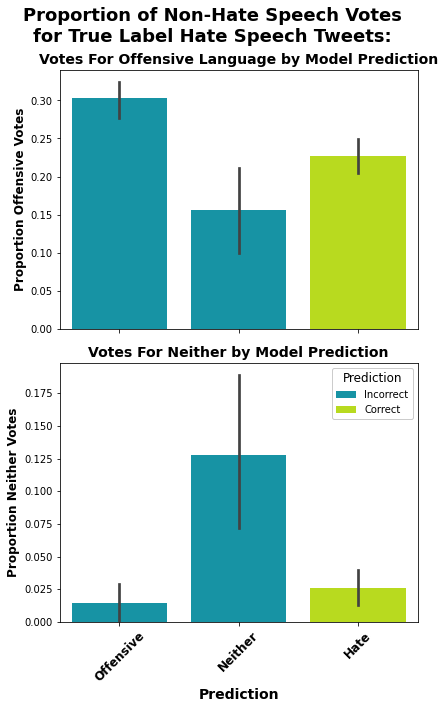

In [182]:
## Create a plot to examine any differences between model predicted classes in 
 ## the proportion of total votes for offensive language for tweets labeled as hate speech 
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(6,10),sharex=True)
sns.barplot(x='prediction',
                      y='proportion off',
                      palette='nipy_spectral',
                      hue='correct',
                      data=predictions_hate_df,
                      dodge=False,
                      ax=ax1)
labels = ['Incorrect', 'Correct']
ax1.set_title('Votes For Offensive Language by Model Prediction', fontsize=14, weight='bold')
ax1.set_xlabel('', fontsize=14, weight='bold')
ax1.set_ylabel('Proportion Offensive Votes', fontsize=12, weight='bold')
ax1.legend_.remove()


## Create a plot to examine any differences between model predicted classes in 
 ## the proportion of total votes for neither for tweets labeled as hate speech 
sns.barplot(x='prediction',
                      y='proportion neither',
                      palette='nipy_spectral',
                      hue='correct',
                      data=predictions_hate_df,
                      dodge=False,
                      ax=ax2)
ax2.set_title('Votes For Neither by Model Prediction', fontsize=14, weight='bold')
ax2.set_xlabel('Prediction', fontsize=14, weight='bold')
ax2.set_ylabel('Proportion Neither Votes', fontsize=12, weight='bold')
ax2.set_xticklabels(['Offensive', 'Neither', 'Hate'], rotation=45, fontsize=12, weight='bold')
h, l = ax2.get_legend_handles_labels()
ax2.legend(h, labels, title='Prediction', title_fontsize=12, fontsize=10, framealpha=1)

fig.suptitle('Proportion of Non-Hate Speech Votes\nfor True Label Hate Speech Tweets:', fontsize=18, fontweight='bold')
plt.tight_layout()

> - It appears that the model experienced a similar pattern of difficulty classifying hate speech tweets as the people who voted on the true label of each tweet. All hate speech tweets were classified as such based on majority vote, but sometimes the vote was mixed. For hate speech tweets that received one or more votes for merely offensive language, the model was also likely to misclassify as offensive langauge. And for hate speech tweets that received one or more votes for neither, the model was also likely to misclassify as neither. 

In [116]:
## Create a DataFrame of false negative classifications of hate speech as 'offensive language'
hs_as_off = mislabeled_hate_speech.groupby('prediction').get_group('offensive')
## Print those tweets
print_full_tweet(hs_as_off, title='Hate Speech Mislabeled as Offensive Language')

************************************************************ 

Hate Speech Mislabeled as Offensive Language 

Number of tweets: 69 

************************************************************ 

0 I hate you niccas! Lol http://t.co/NqSYeQhGOZ 
 ------------------------------------------------------------ 

1 RT'in your own shit now pussy what a joke you'd end up just like all the rest no show chicken shit mother fucker 
 ------------------------------------------------------------ 

2 Fredo was a bitch ass nigga. How niggas fire over 20 shots at his pops but he didn't get off 1 cuz he dropped the gun smh 
 ------------------------------------------------------------ 

3 RT @HG_Shit: Mfs still in the same spot as 3yrs ago. Beefing with the same nighas. Sleeping with the same hoes. Eating from the same restau&#8230; 
 ------------------------------------------------------------ 

4 RT @YABOYLILB: If I ride up to your bitch in these then... homie consider yourself a single nigga. http://

Of the 78 hate speech tweets incorrectly labeled as merely 'offensive language' by the model, several of them do not clearly appear to be hate speech at least to me. 
 - For example, the following tweet certainly contains language most would classify as offensive. However, in the context it appears this appears to possibly be an overall positive tweet and may be an example of a minority group reclaiming a slur for their own use. <br> **15: Wish I coulda said more to @EmmaleeeParkerr tonight. Good seeing you fag. &#128540;** <br>
 - In another example, the following tweet is certainly offensive and uses what is now most often considered a slur for referring to those with intellectual disabilities. However, it is not targeting any specific person or inciting violence or harm against a marginalized group. As such, it is not clear cut that this violates Twitter's hateful conduct policy. <br> **27: DeeDee, Patrick, Ed, Sheen, Timmy's Dad, Beavis &amp; Butthead, Peter Griffin. This is just a list of SOME mentally retarded cartoon characters.** 
 - Certain versions of the n-word such as "nigga", "nicca", "niggah", and "nigguh" are frequently used by black people in a way that reclaims the original word. While many people still regard these versions as offensive, especially when appropriated by other racial groups, these words are not as strongly associated with clear cut hate speech as the original (n\***er). So depending on context and who is using the word, the following tweets are some examples that voters classified as hate speech but that the model labeled as 'offensive':
   - **55: ' Happppppy Birthdayyyy &#1041191;&#1041196;&#1043215; lol . Niggahs is really 21 in this bitch &#1043358;&#1041219; . http://t.co/YatU7pbsHX**
   - **63: "Don't worry about the nigga you see, worry about the nigga you DON'T see... Dat's da nigga fuckin yo bitch."**
   - **44: RT @xDSmooth: The way this niggah just flinched at this movie was #priceless @1BookieG**
 - Similar to the above, the word "hoe" shows up several times in a way that I'm not sure can clearly be considered hate speech, and not just offensive language. Again, depending on who is using the word and the context, the following may or may not be considered hate speech against women:
   - **74: Lmao let these hoes be hoes ain't no Savin nem**
   - **18: Fucking with these hoes nigga don't be no dumby**<br><br>
   
One area where the model was weak in correctly classifying hate speech and misclassifying it as merely offensive language were instances of direct threats, wishing someone harm, or the use of slurs to degrade specific inidividuals such as the following:
 - **12: @IWantHis_Heart Ok u fat precious lookin ass bitch, u big fat back at the barnyard lookin ass bitch. I can fix my grammar but u still fat**
 - **22: @kieffer_jason here let me say it more clearly since your retarded ass don't understand**
 - **41: Lol you're a cunt liar and I hope you drop dead k :-)**
 - **53: @QUAN1T0 You retarded bruh lol**
 - **65: @sho_time_ @MitchVorce chill ur pussy gay af**
 - **72 RT @__bettyboo: You better pray I don't send your nudes out bitch**
 - **75 it means that im following orders and being subordinate. sue me, ya dyke** <br>

This issue might be partially addressed by incorporating whether or not a tweet tags someone when such derogatory and/or threatening language is used. However this would not catch cases where no specific individual is tagged or when these statements are made about protected categories.

In [117]:
## Create a DataFrame of false negative classifications of hate speech as 'neither'
hs_as_neither = mislabeled_hate_speech.groupby('prediction').get_group('neither')
## Print those tweets
print_full_tweet(hs_as_neither, title='Hate Speech Mislabeled as Neither')

************************************************************ 

Hate Speech Mislabeled as Neither 

Number of tweets: 30 

************************************************************ 

0 So I decided to drive to the good walmart where the colored folks don't go bc it's food here. 
 ------------------------------------------------------------ 

1 @yawlknow @HoskinsTy96 "all of these rednecks and none of them can keep the fire lit" &#128514;&#128514; 
 ------------------------------------------------------------ 

2 Not trying to follow any spooks, no offense ... 
 ------------------------------------------------------------ 

3 @BraxCity29 @maria_obregon_g @sophia_freeman1 3/4 of a citizen. I said it for you maria you spic 
 ------------------------------------------------------------ 

4 looking like a hillbilly and not matching is what I do best goodnight losers http://t.co/caGHBLKAXQ 
 ------------------------------------------------------------ 

5 @AnthonyCumia 
You be totally corr

Of the 29 hate speech tweets incorrectly labeled as neither hate speech nor 'offensive language' by the model, a few do not seem to be clear cut as hate speech. 
 - For example, the following tweet is someone referring to herself and it's not particularly hateful. Voters that classified this tweet as hate speech may have objected to the use of the word "hillbilly", but she's applying the word to herself and there is no ill intent. <br> **4 looking like a hillbilly and not matching is what I do best goodnight losers http://t.co/caGHBLKAXQ** <br>
 - In another example, the following tweet is not hate speech if "Yankees" is referring to a team. Team rivalries exist and there is no threat or actual ill intent to the team in this tweet. Simply saying that you hate something does not constitute hate speech. <br> **8: @erinscafe We hate the Yankees though, right? I feel like I'm really good at hating them.** 
 - As seen above, certain versions of the n-word such as "nigga", "nicca", "niggah", and "nigguh" are frequently used by black people in a way that reclaims the original word. While many people still regard these versions as offensive, especially when appropriated by other racial groups, these words are not as strongly associated with clear cut hate speech as the original (n\***er). So depending on context and who is using the word, the following tweets are some examples that voters classified as hate speech but that the model labeled as 'offensive':
   - **17: Told my dad to go buy cookies for the graduation reception...this nigga bought Oreos.**
   - **23: I already know you trash if being tatted is on the list of things you want in a nigga..**<br><br>
   
Again, one area where the model was weak in correctly classifying hate speech and misclassifying it as neither hate speech nor offensive language were instances of direct threats, wishing someone harm, or the use of slurs to degrade specific inidividuals such as the following:
 - **3: @BraxCity29 @maria_obregon_g @sophia_freeman1 3/4 of a citizen. I said it for you maria you spic**
 - **13: "@NotoriousBM95: @_WhitePonyJr_ Ariza is a snake and a coward" but at least he isn't a cripple like your hero Roach lmaoo**
 - **15: Of course my #faith for #baseball is off this year. BECAUSE OF #BARRYBONDS you goddamn retards!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! #morons**
 - **21: @EvanDMyers @nineinchessoft you have a redneck attitude. The same people that think Benghazzi is real think Fox fake nws is real. Your one**
 - **22: @Flow935 jus wanted to let y&#225;ll know hope the hurricane kills your soca sunday trash #LORDWILLIN** <br>

This issue might be partially addressed by incorporating whether or not a tweet tags someone when such derogatory and/or threatening language is used. However this would not catch cases where no specific individual is tagged or when these statements are made about protected categories.<br>

The model also had issues picking up on less commonly used slurs such as "coon", "spic", "spook", "colored people/folks", "muzzies", "raghead", "monkey", and modified versions of the n-word such as "niggerous" and "niggress". It also did not pick up very well on slang commonly used to refer to white people such as "redneck" and "bird". 
 

In [119]:
## Store a list of all lemmatized tokens from hate speech mislabeled as 
 ## offensive language and display the 25 most frequently appearing tokens
hate_as_off_tokens = get_token_list(mislabeled_hate_speech.groupby('prediction').get_group('offensive'),
                                    'lemma tokens', freq=True)


********** lemma tokens Summary **********

Number of unique words = 329


token  count
0    bitch     35
1      hoe     22
2    nigga     18
3     like      7
4      fat      7
5      lol      6
6     fuck      6
7     shit      5
8    pussy      5
9      get      5
10   y'all      5
11   ain't      4
12    love      4
13    hate      3
14   white      3
15    back      3
16    talk      3
17   broke      3
18     gay      3
19    know      3
20  niggah      3
21    dyke      3
22    lmao      3
23  niccas      2
24   still      2

In [120]:
## Store a list of all lemmatized tokens from hate speech mislabeled as 
 ## neither and display the 25 most frequently appearing tokens
hate_as_neither_tokens = get_token_list(mislabeled_hate_speech.groupby('prediction').get_group('neither'),
                                    'lemma tokens', freq=True)


********** lemma tokens Summary **********

Number of unique words = 193


token  count
0      like      4
1     trash      4
2      good      3
3   colored      3
4        go      3
5   redneck      3
6     think      3
7      folk      2
8      none      2
9       dem      2
10   monkey      2
11   though      2
12    right      2
13  cracker      2
14     full      2
15      one      2
16     real      2
17      see      2
18  decided      1
19    drive      1
20  walmart      1
21     food      1
22     keep      1
23     fire      1
24      lit      1

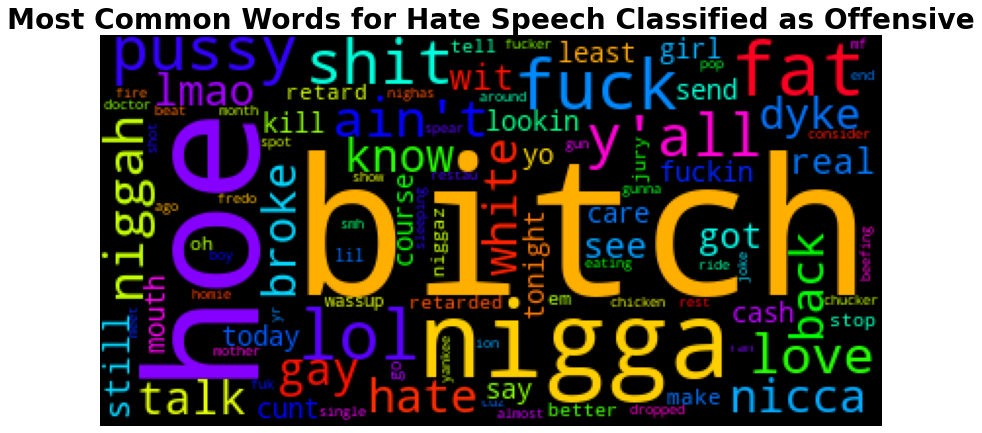

In [121]:
## Create a word cloud visualization of the most frequently used words 
 ## in hate speech tweets that were mislabeled as merely offensive language
plot_wordcloud(hate_as_off_tokens, 'Hate Speech Classified as Offensive');

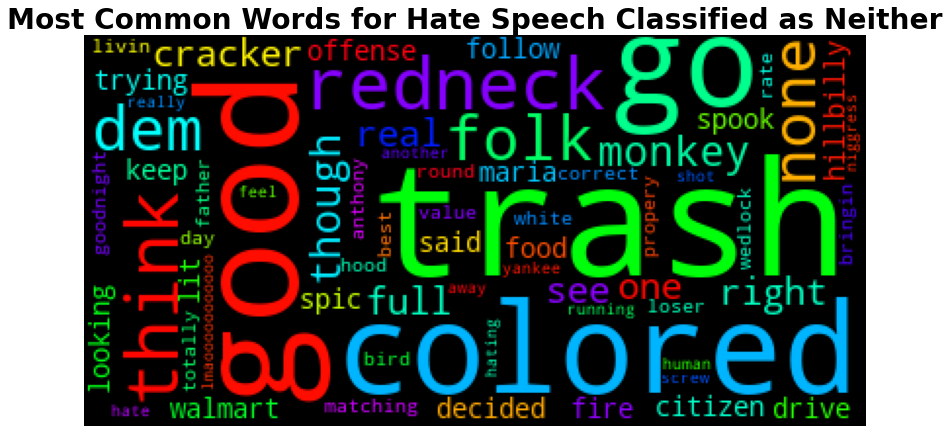

In [122]:
## Create a word cloud visualization of the most frequently used words 
 ## in hate speech tweets that were mislabeled as neither
plot_wordcloud(hate_as_neither_tokens, 'Hate Speech Classified as Neither');

#### Analyzing False Positives for Hate Speech

In [134]:
## Create a DataFrame of false positive classifications of hate speech 
 ## (true label either offensive language or neither)
fp_hate_speech = incorrect_preds_df.groupby('prediction').get_group('hate speech')
# fp_hate_speech

In [191]:
## Create a DataFrame of predictions for all tweets with true label of offensive
predictions_off_df = predictions_df.groupby('true label').get_group('offensive')
## Create a DataFrame of predictions for all tweets with true label of neither
predictions_neither_df = predictions_df.groupby('true label').get_group('neither')

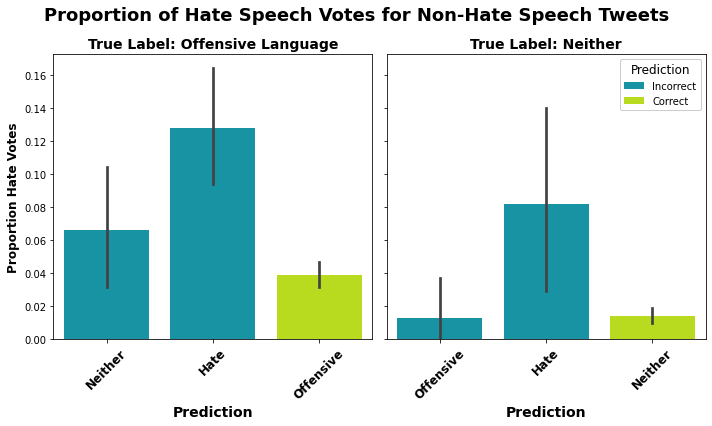

In [206]:
## Create a plot to examine any differences between model predicted classes in 
 ## the proportion of total votes for hate speech for tweets labeled as offensive 
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,6),sharey=True)
sns.barplot(x='prediction',
                      y='proportion hate',
                      palette='nipy_spectral',
                      hue='correct',
                      data=predictions_off_df,
                      dodge=False,
                      ax=ax1)
labels = ['Incorrect', 'Correct']
ax1.set_title('True Label: Offensive Language', fontsize=14, weight='bold')
ax1.set_xlabel('Prediction', fontsize=14, weight='bold')
ax1.set_ylabel('Proportion Hate Votes', fontsize=12, weight='bold')
ax1.set_xticklabels(['Neither', 'Hate', 'Offensive'], rotation=45, fontsize=12, weight='bold')
ax1.legend_.remove()


## Create a plot to examine any differences between model predicted classes in 
 ## the proportion of total votes for hate speech for tweets labeled as neither
sns.barplot(x='prediction',
                      y='proportion hate',
                      palette='nipy_spectral',
                      hue='correct',
                      data=predictions_neither_df,
                      dodge=False,
                      ax=ax2)
labels = ['Incorrect', 'Correct']
ax2.set_title('True Label: Neither', fontsize=14, weight='bold')
ax2.set_xlabel('Prediction', fontsize=14, weight='bold')
ax2.set_ylabel('', fontsize=12, weight='bold')
ax2.set_xticklabels(['Offensive', 'Hate', 'Neither'], rotation=45, fontsize=12, weight='bold')
h, l = ax2.get_legend_handles_labels()
ax2.legend(h, labels, title='Prediction', title_fontsize=12, fontsize=10, framealpha=1)

fig.suptitle('Proportion of Hate Speech Votes for Non-Hate Speech Tweets', fontsize=18, fontweight='bold')
plt.tight_layout()

> - It appears that the model experienced a similar pattern of difficulty classifying tweets as the people who voted on the true label of each tweet. All tweets were classified based on majority vote, but sometimes the vote was mixed. For both offensive language and neither tweets that received one or more votes for hate speech, the model was also more likely to misclassify as those as hate speech.

In [132]:
## Create a DataFrame of false positive classifications of offensive language as hate speech
off_as_hs = fp_hate_speech.groupby('true label').get_group('offensive')
## Print those tweets
print_full_tweet(off_as_hs, title='Offensive Language Mislabeled as Hate Speech')

************************************************************ 

Offensive Language Mislabeled as Hate Speech 

Number of tweets: 78 

************************************************************ 

0 @Benny_Balboa not to yall thou! Yalll fucking glad bag trash 
 ------------------------------------------------------------ 

1 you gotta be a new breed of retarded if you do that. http://t.co/PeinRwsZzq 
 ------------------------------------------------------------ 

2 RT @damola49: @Ademulla happy birthday to the gayest nigga missing you and follow my new account british cunt 
 ------------------------------------------------------------ 

3 &#8220;@crystalinag: finger a bitch w/ my trigger finger&#8221; nigga shut up 
 ------------------------------------------------------------ 

4 RT @PinkDuckTwist: LMFAO WTF &#8220;@MakeMeSpazz: &#8220;@TheKingSimp: Niggas on here really retarded http://t.co/arhySCAMu6&#8221; &#128553;&#128514;&#9996;&#65039; I'm tf out!!&#8221; 
 ---------------------

Of the 78 offensive language tweets incorrectly labeled as hate speech by the model, a few seem like they may meet Twitter's definition of prohibited hateful conduct even though the majority of votes did not classify them as such. 
 - For example, the following tweet seems like it is targeting a specific individual and is using a slur associated with a disability to degrade someone. This would seem to be in direct violation of Twitter's hateful conduct policy. <br> **32: @TakingBackSunda @NYCGreenfield @lsarsour that's not how you resist, you worthless retard. Do you need a dictionary?** <br>
 - In another example, the following tweets seems similar to the above in that they target or mention a specific person and aim at degrading them using a slur referring to sexual orientation. Two of them are even specifically aimed at stopping the mentioned individuals from expressing themselves.
   - **37: @shoe1945 @NotoriousBM95 @333England shut ur faggot ass up you thirsty pussy** 
   - **44: This nigga Magic Johnson got a Grade A faggot for a son &#128514;&#128514;.. He had to have done some terrible shit growin up lol..**
   - **55: @Roscoedash shut the fuck up, your wack as fuck. Garbage mohawk having faggot, stop making music and shovel my snow scrub.**<br><br>
   
In some instances, the model seems to be misclassifying offensive language tweets as hate speech based on versions of the n-word such as "nigga", "nicca", "niggah", and "nigguh" when the context of the tweet does not seem to meet the specifications of hateful conduct. However, some of these tweets seem very similar to other tweets that the voters labeled as hate speech, but that the model classified as merely offensive. So depending on context and who is using the word, the following tweets are some examples that voters classified as offensive, but that the model labeled as hate speech:
  - **7: I'm coming for that no 1 spot nigguh @Nichollsodeon**
  - **35: &#8220;@FunnyPicsDepot: When the nigga with the aux cord playin some trash shit http://t.co/LMP5BeplVy&#8221; @JWilko7**
  - **47: @KazAtta LOL this is why u my nig**<br><br>
   
The model also misclassifies offensive tweets as hate speech based on the presence of slurs commonly used in hate speech tweets, but in the context are not being used as such. 
 - For example, some tweets seem to be reclaiming certain slurs and/or using them as terms of endearment in a way that could be considered offensive, but doesn't constitute hate speech:
  - **19: @jacksparenohoe let's hang out nigger**
  - **66: @laser_beam26 text me fag**
  - **77: @jaaaaaade__ Shut up. And miss you too fag**
 - In other examples, the use of the slurs seems to be part of a retelling of an occurrence or conversation that involved hate speech, but is not hate speech itself:
  - **24: Nile... RT @JosephBananas I'm really sad that I don't have enough friends to ever be called "a pack of niggers" with. That's my fuckin dream**
  - **73: some guy said I was wearing leggings and laughed and called me a fag. they're JEGGINGS, asshole.**

Additionally, it seems like the model may be picking up on the word "trash" and using that to misclassify tweets as hate speech, potentially when used in the same tweet with other specific words:
 - **0: @Benny_Balboa not to yall thou! Yalll fucking glad bag trash**
 - **39: Who the hell is gonna buy your shit when your dirty panties and trash are clearly in the background of the picture**

In [133]:
## Create a DataFrame of false positive classifications of offensive language as hate speech
neither_as_hs = fp_hate_speech.groupby('true label').get_group('neither')
## Print those tweets
print_full_tweet(neither_as_hs, title='Neither Mislabeled as Hate Speech')

************************************************************ 

Neither Mislabeled as Hate Speech 

Number of tweets: 23 

************************************************************ 

0 Aren't these little border jumpers supposed to be in school 
 ------------------------------------------------------------ 

1 RT @Black__Elvis: My favorite episode of Friends is the one where blacks mysteriously vanish and unemployed white people find affordable ho&#8230; 
 ------------------------------------------------------------ 

2 National Review calls #gay marriage 'lawlessness' http://t.co/QpTreDa6yv #oregon #tcot #gop #NOM #lol #teabaggers 
 ------------------------------------------------------------ 

3 @RudyJay711 Asains had to take the Wu Tang Clan; the draft was suppose to be for half breed like me and @MikeTaylorShow #FallingInTheDraft 
 ------------------------------------------------------------ 

4 You all are retarded if you really Kendrick was trying to diss all those rappers, don

Of the 23 neither tweets incorrectly labeled as hate speech by the model, several seem like they should have at least been labeled as offensive based on the use of slurs. For example:
 - **4: You all are retarded if you really Kendrick was trying to diss all those rappers, don't think just cuz names were said he was coming at them**
 - **5: Looks like a tool but is useful as a clay hammer #fag @hOPPondis http://t.co/K7wqlAWRwM**
 - **6: I I haven't watched a single episode of #LHHNY however I'm watching the reunion. This coon shit. I mean the levels of ratcheticity** 
 - **18 Being coons &#8220;@FatTravis_6200: At??? @TiFFANY_P0RSCHE: Y'all are amazing."&#8221;**<br>
 
Others seem like they could very likely be hate speech depending on context.
 - For example, the following tweet uses a slur to degrade two specific people:
   - **8: The two ringless fags RT @EverybodyHatesX: Barkley &amp; Reggie were talking nonsense the entire game**
 - This one tells someone to log off (presumably an attempt to stop them from expressing themselves online) and uses a slur to degrade them:
   - **16: Log off nigger RT @PoloKingBC: #relationshipgoals http://t.co/Ge9koImYGj**<br><br>   

Somewhat interestingly, the model is picking up on tweets that could absolutely be considered racist, but that may not technically meet Twitter's definition of hateful conduct. For example:
 - **0: Aren't these little border jumpers supposed to be in school**
 - **1: RT @Black__Elvis: My favorite episode of Friends is the one where blacks mysteriously vanish and unemployed white people find affordable ho&#8230;**


And, as seen previously, the model appears to be picking up on the word "trash" when in the presence of other specific words when the context does not clearly indicate that the text is hate speech. For example:
 - **9: The Saints are pure trash lol smh**
 - **19 Photo: Giving you that trailer park trash. #transformthursday #ladykimora #vegasqueens #vegasshowgirls http://t.co/LjejFufULK**
 - **21: @Blackman38Tide bandana Orian. They called me trailer trash for wearing my lil country getup &#128545;**

In [184]:
## Store a list of all lemmatized tokens for offensive language mislabeled as 
 ## hate speech and display the 25 most frequently appearing tokens
off_as_hate_tokens = get_token_list(off_as_hs, 'lemma tokens', freq=True)


********** lemma tokens Summary **********

Number of unique words = 346


token  count
0      nigga     22
1      bitch     15
2     faggot     11
3       cunt     10
4       like      9
5       fuck      8
6       shut      7
7        hoe      6
8        fag      6
9     nigger      6
10    stupid      5
11      shit      5
12   fucking      4
13     trash      4
14  retarded      4
15     pussy      4
16        ur      4
17      ugly      4
18     white      4
19    fuckin      4
20      ever      4
21       lol      4
22         w      3
23    really      3
24       guy      3

In [185]:
## Store a list of all lemmatized tokens for neither mislabeled as 
 ## hate speech and display the 25 most frequently appearing tokens
neither_as_hate_tokens = get_token_list(neither_as_hs, 'lemma tokens', freq=True)


********** lemma tokens Summary **********

Number of unique words = 186


token  count
0        lol      4
1      trash      4
2     muslim      4
3       like      3
4     attack      3
5     school      2
6    episode      2
7      black      2
8     people      2
9        gay      2
10  marriage      2
11     think      2
12       fag      2
13      coon      2
14    beaner      2
15     child      2
16   trailer      2
17   country      2
18    little      1
19    border      1
20    jumper      1
21  supposed      1
22  favorite      1
23    friend      1
24       one      1

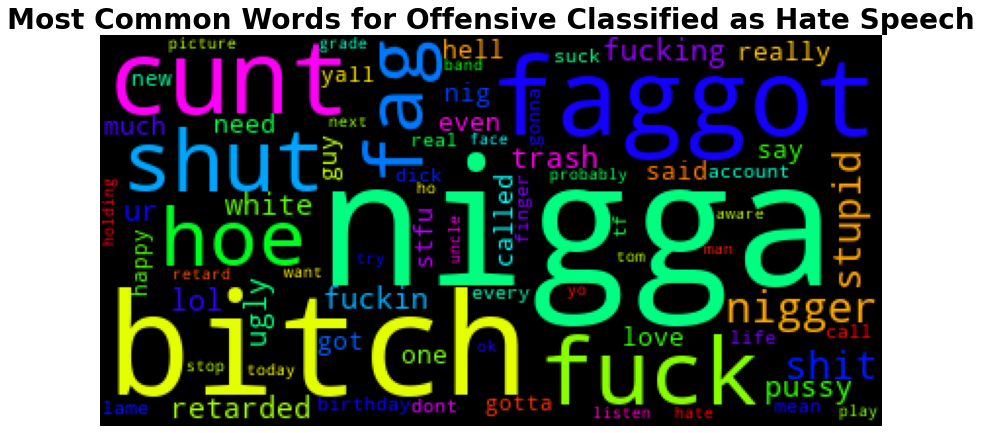

In [186]:
## Create a word cloud visualization of the most frequently used words 
 ## in offensive language tweets that were mislabeled as hate speech
plot_wordcloud(off_as_hate_tokens, 'Offensive Classified as Hate Speech');

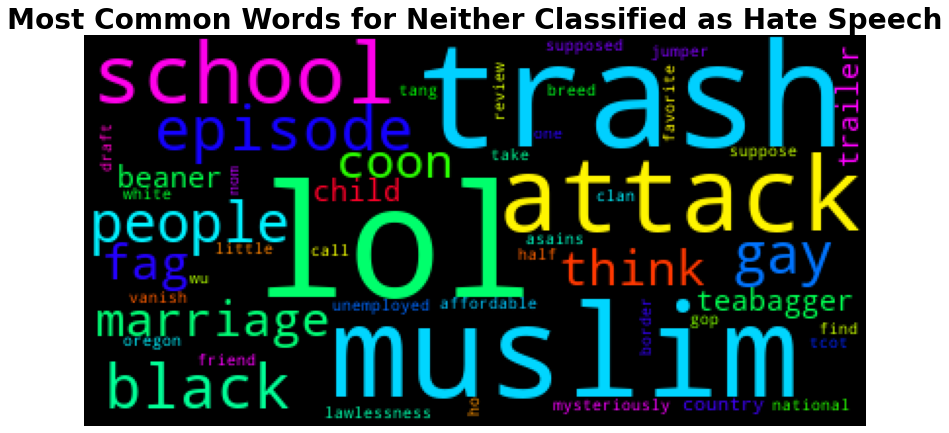

In [187]:
## Create a word cloud visualization of the most frequently used words 
 ## in neither tweets that were mislabeled as hate speech
plot_wordcloud(neither_as_hate_tokens, 'Neither Classified as Hate Speech');

# Conclusions/Recommendations